In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


from catboost import Pool, CatBoostClassifier

from tqdm import tqdm

%matplotlib inline
sns.set(style='darkgrid', font_scale=1.5)

In [17]:
data = pd.read_csv('../datasets/added_pos1_metrics_windowed.csv', index_col=[0, 1])

In [18]:
data = data.droplevel(0)

In [19]:
data.head()

,x_mean,x_std,x_max,x_min,x_energy,x_iqr,y_mean,y_std,y_max,y_min,...,z_iqr_pos1,xy_corr_pos1,xz_corr_pos1,yz_corr_pos1,height,mass,position,is_valid,age,sex
level_1,,,,,,,,,,,,,,,,,,,,,
1673,11156.76,123.532772,11380.0,10836.0,1.244884e+08,177.0,1158.80,73.172275,1348.0,920.0,...,485.0,-0.203383,0.750925,-0.452449,185,75,1,0,18,1
1698,11156.88,128.858961,11380.0,10836.0,1.244924e+08,193.0,1137.96,69.416023,1300.0,920.0,...,485.0,-0.203383,0.750925,-0.452449,185,75,1,0,18,1
1723,11154.36,134.410311,11532.0,10836.0,1.244376e+08,190.0,1088.32,171.829072,1380.0,164.0,...,485.0,-0.203383,0.750925,-0.452449,185,75,1,0,18,1
1748,10998.28,415.506022,11532.0,9384.0,1.211331e+08,323.0,853.36,499.190851,1380.0,-1032.0,...,485.0,-0.203383,0.750925,-0.452449,185,75,1,0,18,1
1773,10883.04,409.575930,11532.0,9384.0,1.186066e+08,543.0,537.68,622.192456,1380.0,-1032.0,...,485.0,-0.203383,0.750925,-0.452449,185,75,1,0,18,1


### Определение позиции

In [27]:
def getBestModelCB(X_train, X_test, y_train, y_test, params_grid,
                   cat_feature=None, plot=False, **kwargs):
    
    train_pool = Pool(X_train, label=y_train, cat_features=cat_feature, 
                      feature_names=list(X_train.columns))
    test_pool = Pool(X_test, label=y_test, cat_features=cat_feature, 
                     feature_names=list(X_test.columns))
    
    model = CatBoostClassifier(logging_level='Silent', **kwargs)
    
    results = model.grid_search(
        param_grid={
            'n_estimators': [100, 200, 300, 500],
            'max_depth' : np.arange(3, 7),
            'learning_rate': np.linspace(0.0125, 0.6, 10)
        },
        X=train_pool,
        plot=plot,
        verbose=False
    )
    
    best_params = results['params']
    
    model = CatBoostClassifier(use_best_model=True, random_seed=0, 
                           **best_params, **kwargs)

    model.fit(train_pool, eval_set=test_pool, metric_period=100)
    
    return model

In [21]:
data = data.drop(['is_valid', 'age', 'sex'], axis=1)

In [22]:
y = data['position']
X = data.drop('position', axis=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=1234
)

params_grid = {
            'n_estimators': [100, 200, 300, 500],
            'max_depth' : np.arange(3, 7),
            'learning_rate': np.linspace(0.0125, 0.6, 10)
        }

In [24]:
best_model = getBestModelCB(X_train, X_test, y_train, y_test,
                            params_grid=params_grid,
                            loss_function='MultiClass')

0:	learn: 0.5570815	test: 0.5589569	best: 0.5589569 (0)	total: 9.05ms	remaining: 4.52s
100:	learn: 0.0074975	test: 0.0216025	best: 0.0216025 (100)	total: 728ms	remaining: 2.87s
200:	learn: 0.0029569	test: 0.0145884	best: 0.0145884 (200)	total: 1.58s	remaining: 2.35s
300:	learn: 0.0016803	test: 0.0126702	best: 0.0126702 (300)	total: 2.36s	remaining: 1.56s
400:	learn: 0.0011200	test: 0.0117522	best: 0.0117522 (400)	total: 3.12s	remaining: 771ms
499:	learn: 0.0008308	test: 0.0108660	best: 0.0108660 (499)	total: 4.06s	remaining: 0us

bestTest = 0.0108659853
bestIteration = 499



In [25]:
sorted_metrics = []

for value, name in sorted(
    zip(best_model.get_feature_importance(fstr_type="FeatureImportance"), 
        X_train.columns), 
    reverse=True
):
    sorted_metrics.append(name)
    print("{}\t{:.2f}".format(name, value))

x_max	16.27
x_std	7.23
xz_corr	6.22
x_min	5.03
y_std	4.97
y_energy	4.54
x_mean	3.80
y_max	3.68
z_max	3.33
y_min	3.05
sma	2.83
z_mean	2.79
x_mean_pos1	2.73
sma_pos1	2.42
y_iqr	2.36
z_energy	2.09
z_iqr_pos1	1.99
z_max_pos1	1.86
x_min_pos1	1.69
x_energy	1.54
z_min	1.49
x_iqr_pos1	1.47
y_mean	1.45
y_energy_pos1	1.21
x_std_pos1	1.13
y_max_pos1	1.09
yz_corr	1.09
x_max_pos1	1.08
height	1.06
z_iqr	1.00
y_mean_pos1	0.83
x_energy_pos1	0.79
z_mean_pos1	0.79
z_min_pos1	0.62
z_std	0.59
xy_corr	0.59
y_iqr_pos1	0.57
z_std_pos1	0.49
y_std_pos1	0.48
x_iqr	0.46
z_energy_pos1	0.35
yz_corr_pos1	0.34
xz_corr_pos1	0.25
y_min_pos1	0.17
xy_corr_pos1	0.13
mass	0.04


In [26]:
sorted_metrics

['x_max',
 'x_std',
 'xz_corr',
 'x_min',
 'y_std',
 'y_energy',
 'x_mean',
 'y_max',
 'z_max',
 'y_min',
 'sma',
 'z_mean',
 'x_mean_pos1',
 'sma_pos1',
 'y_iqr',
 'z_energy',
 'z_iqr_pos1',
 'z_max_pos1',
 'x_min_pos1',
 'x_energy',
 'z_min',
 'x_iqr_pos1',
 'y_mean',
 'y_energy_pos1',
 'x_std_pos1',
 'y_max_pos1',
 'yz_corr',
 'x_max_pos1',
 'height',
 'z_iqr',
 'y_mean_pos1',
 'x_energy_pos1',
 'z_mean_pos1',
 'z_min_pos1',
 'z_std',
 'xy_corr',
 'y_iqr_pos1',
 'z_std_pos1',
 'y_std_pos1',
 'x_iqr',
 'z_energy_pos1',
 'yz_corr_pos1',
 'xz_corr_pos1',
 'y_min_pos1',
 'xy_corr_pos1',
 'mass']

In [27]:
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       969
           2       1.00      0.99      0.99       948
           3       1.00      1.00      1.00       898

    accuracy                           1.00      2815
   macro avg       1.00      1.00      1.00      2815
weighted avg       1.00      1.00      1.00      2815



In [32]:
from collections import defaultdict
from collections import OrderedDict

import time

In [33]:
history = defaultdict(list)

Лучшие используемые метрики брались из предсказания горбатости.

In [34]:
for i in tqdm(range(5, len(sorted_metrics))):
    metrics = sorted_metrics[:i]
    
    model = getBestModelCB(X_train[metrics], X_test[metrics], y_train, y_test,
                        params_grid=params_grid,
                        loss_function='MultiClass')
    
    start_time = time.time_ns()
    y_pred = model.predict(X_test)
    history['time_predict'].append(time.time_ns() - start_time)
    
    accuracy = accuracy_score(y_test, y_pred)
    history['accuracy'].append(accuracy)

  0%|          | 0/42 [00:00<?, ?it/s]

0:	learn: 0.4460966	test: 0.4567149	best: 0.4567149 (0)	total: 1.74ms	remaining: 867ms
100:	learn: 0.0047614	test: 0.0219481	best: 0.0219481 (100)	total: 124ms	remaining: 489ms
200:	learn: 0.0019811	test: 0.0178767	best: 0.0178767 (200)	total: 283ms	remaining: 421ms
300:	learn: 0.0012376	test: 0.0161936	best: 0.0161936 (300)	total: 406ms	remaining: 268ms


  2%|▏         | 1/42 [01:09<47:11, 69.06s/it]

400:	learn: 0.0008907	test: 0.0155821	best: 0.0155821 (400)	total: 561ms	remaining: 138ms
499:	learn: 0.0006965	test: 0.0150817	best: 0.0150817 (499)	total: 699ms	remaining: 0us

bestTest = 0.01508165505
bestIteration = 499

0:	learn: 0.3831765	test: 0.3946938	best: 0.3946938 (0)	total: 1.49ms	remaining: 746ms
100:	learn: 0.0023825	test: 0.0185784	best: 0.0185784 (100)	total: 123ms	remaining: 486ms
200:	learn: 0.0010238	test: 0.0171159	best: 0.0171159 (200)	total: 304ms	remaining: 453ms
300:	learn: 0.0006478	test: 0.0164165	best: 0.0164165 (300)	total: 429ms	remaining: 283ms


  5%|▍         | 2/42 [02:19<46:36, 69.91s/it]

400:	learn: 0.0004725	test: 0.0165204	best: 0.0164165 (300)	total: 591ms	remaining: 146ms
499:	learn: 0.0003782	test: 0.0162071	best: 0.0162071 (499)	total: 712ms	remaining: 0us

bestTest = 0.01620711418
bestIteration = 499

0:	learn: 0.4055407	test: 0.4162933	best: 0.4162933 (0)	total: 1.69ms	remaining: 844ms
100:	learn: 0.0025461	test: 0.0177281	best: 0.0177281 (100)	total: 123ms	remaining: 487ms
200:	learn: 0.0010520	test: 0.0157574	best: 0.0157574 (200)	total: 278ms	remaining: 413ms
300:	learn: 0.0006671	test: 0.0149843	best: 0.0149843 (300)	total: 399ms	remaining: 264ms


  7%|▋         | 3/42 [03:27<44:45, 68.86s/it]

400:	learn: 0.0004833	test: 0.0144431	best: 0.0144431 (400)	total: 546ms	remaining: 135ms
499:	learn: 0.0003810	test: 0.0141175	best: 0.0141175 (499)	total: 666ms	remaining: 0us

bestTest = 0.01411748078
bestIteration = 499

0:	learn: 0.4453251	test: 0.4423361	best: 0.4423361 (0)	total: 1.66ms	remaining: 830ms
100:	learn: 0.0026551	test: 0.0138021	best: 0.0138021 (100)	total: 124ms	remaining: 489ms
200:	learn: 0.0011748	test: 0.0131078	best: 0.0131078 (200)	total: 255ms	remaining: 380ms
300:	learn: 0.0007633	test: 0.0125162	best: 0.0125162 (300)	total: 388ms	remaining: 256ms


 10%|▉         | 4/42 [04:35<43:25, 68.56s/it]

400:	learn: 0.0005720	test: 0.0127816	best: 0.0125162 (300)	total: 518ms	remaining: 128ms
499:	learn: 0.0004473	test: 0.0128005	best: 0.0125162 (300)	total: 641ms	remaining: 0us

bestTest = 0.0125161968
bestIteration = 300

Shrink model to first 301 iterations.
0:	learn: 0.4168965	test: 0.4234011	best: 0.4234011 (0)	total: 1.63ms	remaining: 812ms
100:	learn: 0.0019876	test: 0.0145887	best: 0.0145887 (100)	total: 128ms	remaining: 504ms
200:	learn: 0.0008096	test: 0.0129090	best: 0.0129090 (200)	total: 277ms	remaining: 413ms
300:	learn: 0.0005147	test: 0.0125936	best: 0.0125936 (300)	total: 400ms	remaining: 264ms


 12%|█▏        | 5/42 [05:46<42:55, 69.62s/it]

400:	learn: 0.0003838	test: 0.0122817	best: 0.0122817 (400)	total: 530ms	remaining: 131ms
499:	learn: 0.0003113	test: 0.0120385	best: 0.0120385 (499)	total: 653ms	remaining: 0us

bestTest = 0.01203850718
bestIteration = 499

0:	learn: 0.3913614	test: 0.3935283	best: 0.3935283 (0)	total: 4.95ms	remaining: 2.47s
100:	learn: 0.0020518	test: 0.0164074	best: 0.0164074 (100)	total: 153ms	remaining: 606ms
200:	learn: 0.0008769	test: 0.0149061	best: 0.0149061 (200)	total: 290ms	remaining: 432ms
300:	learn: 0.0005616	test: 0.0148420	best: 0.0148420 (300)	total: 416ms	remaining: 275ms


 14%|█▍        | 6/42 [06:58<42:06, 70.17s/it]

400:	learn: 0.0004294	test: 0.0149067	best: 0.0148420 (300)	total: 550ms	remaining: 136ms
499:	learn: 0.0003402	test: 0.0144442	best: 0.0144442 (499)	total: 693ms	remaining: 0us

bestTest = 0.01444422795
bestIteration = 499

0:	learn: 0.4039207	test: 0.4178839	best: 0.4178839 (0)	total: 1.3ms	remaining: 647ms
100:	learn: 0.0025503	test: 0.0115873	best: 0.0115873 (100)	total: 96.8ms	remaining: 382ms
200:	learn: 0.0010739	test: 0.0093841	best: 0.0093841 (200)	total: 215ms	remaining: 320ms
300:	learn: 0.0007050	test: 0.0089779	best: 0.0089779 (300)	total: 311ms	remaining: 205ms
400:	learn: 0.0005042	test: 0.0083169	best: 0.0083169 (400)	total: 406ms	remaining: 100ms


 17%|█▋        | 7/42 [08:05<40:23, 69.25s/it]

499:	learn: 0.0003918	test: 0.0081784	best: 0.0081784 (499)	total: 509ms	remaining: 0us

bestTest = 0.008178419424
bestIteration = 499

0:	learn: 0.3415403	test: 0.3519801	best: 0.3519801 (0)	total: 1.63ms	remaining: 814ms
100:	learn: 0.0014720	test: 0.0144036	best: 0.0144036 (100)	total: 129ms	remaining: 510ms
200:	learn: 0.0006542	test: 0.0133659	best: 0.0133659 (200)	total: 265ms	remaining: 395ms
300:	learn: 0.0004386	test: 0.0130734	best: 0.0130734 (300)	total: 438ms	remaining: 290ms


 19%|█▉        | 8/42 [09:14<39:11, 69.17s/it]

400:	learn: 0.0003220	test: 0.0129742	best: 0.0129742 (400)	total: 573ms	remaining: 142ms
499:	learn: 0.0002525	test: 0.0130370	best: 0.0129742 (400)	total: 702ms	remaining: 0us

bestTest = 0.01297415972
bestIteration = 400

Shrink model to first 401 iterations.
0:	learn: 0.3882022	test: 0.4077130	best: 0.4077130 (0)	total: 2.04ms	remaining: 1.02s
100:	learn: 0.0014422	test: 0.0134052	best: 0.0134052 (100)	total: 129ms	remaining: 508ms
200:	learn: 0.0006555	test: 0.0127989	best: 0.0127989 (200)	total: 265ms	remaining: 394ms
300:	learn: 0.0004200	test: 0.0126061	best: 0.0126061 (300)	total: 391ms	remaining: 259ms


 21%|██▏       | 9/42 [10:25<38:24, 69.84s/it]

400:	learn: 0.0003074	test: 0.0124674	best: 0.0124674 (400)	total: 526ms	remaining: 130ms
499:	learn: 0.0002456	test: 0.0124950	best: 0.0124674 (400)	total: 652ms	remaining: 0us

bestTest = 0.01246741012
bestIteration = 400

Shrink model to first 401 iterations.
0:	learn: 0.3992419	test: 0.4242739	best: 0.4242739 (0)	total: 1.87ms	remaining: 935ms
100:	learn: 0.0016309	test: 0.0107552	best: 0.0107552 (100)	total: 138ms	remaining: 544ms
200:	learn: 0.0007052	test: 0.0086335	best: 0.0086335 (200)	total: 282ms	remaining: 419ms
300:	learn: 0.0004648	test: 0.0079835	best: 0.0079835 (300)	total: 417ms	remaining: 276ms


 24%|██▍       | 10/42 [11:43<38:36, 72.40s/it]

400:	learn: 0.0003516	test: 0.0076748	best: 0.0076748 (400)	total: 564ms	remaining: 139ms
499:	learn: 0.0002799	test: 0.0074715	best: 0.0074715 (499)	total: 702ms	remaining: 0us

bestTest = 0.007471499455
bestIteration = 499

0:	learn: 0.4207019	test: 0.4557482	best: 0.4557482 (0)	total: 1.65ms	remaining: 822ms
100:	learn: 0.0016468	test: 0.0141510	best: 0.0141510 (100)	total: 137ms	remaining: 542ms
200:	learn: 0.0007068	test: 0.0118934	best: 0.0118934 (200)	total: 280ms	remaining: 417ms
300:	learn: 0.0004746	test: 0.0113846	best: 0.0113846 (300)	total: 429ms	remaining: 284ms


 26%|██▌       | 11/42 [12:59<37:53, 73.34s/it]

400:	learn: 0.0003503	test: 0.0109229	best: 0.0109229 (400)	total: 571ms	remaining: 141ms
499:	learn: 0.0002767	test: 0.0109022	best: 0.0109022 (499)	total: 705ms	remaining: 0us

bestTest = 0.01090216956
bestIteration = 499

0:	learn: 0.4021532	test: 0.4063401	best: 0.4063401 (0)	total: 1.8ms	remaining: 901ms
100:	learn: 0.0015620	test: 0.0109627	best: 0.0109627 (100)	total: 176ms	remaining: 695ms
200:	learn: 0.0007455	test: 0.0096874	best: 0.0096874 (200)	total: 327ms	remaining: 486ms
300:	learn: 0.0004973	test: 0.0093805	best: 0.0093805 (300)	total: 469ms	remaining: 310ms


 29%|██▊       | 12/42 [14:15<37:08, 74.28s/it]

400:	learn: 0.0003679	test: 0.0090938	best: 0.0090938 (400)	total: 620ms	remaining: 153ms
499:	learn: 0.0002884	test: 0.0090183	best: 0.0090183 (499)	total: 763ms	remaining: 0us

bestTest = 0.009018309212
bestIteration = 499

0:	learn: 0.3720403	test: 0.3809998	best: 0.3809998 (0)	total: 7.45ms	remaining: 3.72s
100:	learn: 0.0017698	test: 0.0117341	best: 0.0117341 (100)	total: 230ms	remaining: 907ms
200:	learn: 0.0008207	test: 0.0094484	best: 0.0094484 (200)	total: 384ms	remaining: 572ms
300:	learn: 0.0005072	test: 0.0085845	best: 0.0085845 (300)	total: 543ms	remaining: 359ms
400:	learn: 0.0003666	test: 0.0081101	best: 0.0081101 (400)	total: 689ms	remaining: 170ms


 31%|███       | 13/42 [15:33<36:24, 75.33s/it]

499:	learn: 0.0002917	test: 0.0078190	best: 0.0078190 (499)	total: 843ms	remaining: 0us

bestTest = 0.007818957914
bestIteration = 499

0:	learn: 0.3873057	test: 0.4064932	best: 0.4064932 (0)	total: 4.68ms	remaining: 2.33s
100:	learn: 0.0020812	test: 0.0085935	best: 0.0085935 (100)	total: 199ms	remaining: 786ms
200:	learn: 0.0009208	test: 0.0055711	best: 0.0055711 (200)	total: 378ms	remaining: 563ms
300:	learn: 0.0005883	test: 0.0044667	best: 0.0044667 (300)	total: 548ms	remaining: 362ms


 33%|███▎      | 14/42 [16:57<36:25, 78.06s/it]

400:	learn: 0.0004250	test: 0.0038903	best: 0.0038903 (400)	total: 726ms	remaining: 179ms
499:	learn: 0.0003325	test: 0.0035551	best: 0.0035551 (499)	total: 893ms	remaining: 0us

bestTest = 0.003555106537
bestIteration = 499

0:	learn: 0.3807720	test: 0.3894648	best: 0.3894648 (0)	total: 2.06ms	remaining: 1.03s
100:	learn: 0.0021369	test: 0.0088445	best: 0.0088445 (100)	total: 170ms	remaining: 673ms
200:	learn: 0.0008930	test: 0.0061464	best: 0.0061464 (200)	total: 346ms	remaining: 515ms
300:	learn: 0.0005736	test: 0.0050646	best: 0.0050646 (300)	total: 530ms	remaining: 350ms
400:	learn: 0.0004336	test: 0.0045768	best: 0.0045768 (400)	total: 710ms	remaining: 175ms
499:	learn: 0.0003415	test: 0.0040230	best: 0.0040230 (499)	total: 886ms	remaining: 0us

bestTest = 0.004023012644
bestIteration = 499



 36%|███▌      | 15/42 [18:22<36:01, 80.06s/it]

0:	learn: 0.3992581	test: 0.3979762	best: 0.3979762 (0)	total: 1.99ms	remaining: 991ms
100:	learn: 0.0019464	test: 0.0082545	best: 0.0082545 (100)	total: 171ms	remaining: 677ms
200:	learn: 0.0008911	test: 0.0060746	best: 0.0060746 (200)	total: 357ms	remaining: 531ms
300:	learn: 0.0005821	test: 0.0050363	best: 0.0050363 (300)	total: 526ms	remaining: 348ms


 38%|███▊      | 16/42 [19:45<35:05, 80.97s/it]

400:	learn: 0.0004361	test: 0.0044472	best: 0.0044472 (400)	total: 702ms	remaining: 173ms
499:	learn: 0.0003339	test: 0.0040779	best: 0.0040779 (499)	total: 871ms	remaining: 0us

bestTest = 0.004077927752
bestIteration = 499

0:	learn: 0.3956857	test: 0.4134372	best: 0.4134372 (0)	total: 2.13ms	remaining: 1.06s
100:	learn: 0.0018550	test: 0.0057433	best: 0.0057433 (100)	total: 174ms	remaining: 685ms
200:	learn: 0.0008034	test: 0.0032509	best: 0.0032509 (200)	total: 349ms	remaining: 519ms
300:	learn: 0.0005048	test: 0.0025916	best: 0.0025916 (300)	total: 519ms	remaining: 343ms


 40%|████      | 17/42 [21:11<34:24, 82.57s/it]

400:	learn: 0.0003690	test: 0.0022003	best: 0.0022003 (400)	total: 696ms	remaining: 172ms
499:	learn: 0.0002950	test: 0.0019691	best: 0.0019691 (499)	total: 863ms	remaining: 0us

bestTest = 0.001969092404
bestIteration = 499

0:	learn: 0.3885553	test: 0.3970346	best: 0.3970346 (0)	total: 1.88ms	remaining: 939ms
100:	learn: 0.0017503	test: 0.0057804	best: 0.0057804 (100)	total: 173ms	remaining: 682ms
200:	learn: 0.0008425	test: 0.0040097	best: 0.0040097 (200)	total: 350ms	remaining: 520ms
300:	learn: 0.0005317	test: 0.0032294	best: 0.0032294 (300)	total: 521ms	remaining: 344ms
400:	learn: 0.0003930	test: 0.0028897	best: 0.0028897 (400)	total: 734ms	remaining: 181ms


 43%|████▎     | 18/42 [22:37<33:22, 83.44s/it]

499:	learn: 0.0003016	test: 0.0025501	best: 0.0025501 (499)	total: 987ms	remaining: 0us

bestTest = 0.002550106208
bestIteration = 499

0:	learn: 0.3704473	test: 0.3849839	best: 0.3849839 (0)	total: 1.96ms	remaining: 978ms
100:	learn: 0.0019811	test: 0.0077584	best: 0.0077584 (100)	total: 209ms	remaining: 826ms
200:	learn: 0.0008403	test: 0.0051142	best: 0.0051142 (200)	total: 431ms	remaining: 641ms
300:	learn: 0.0005277	test: 0.0043903	best: 0.0043903 (300)	total: 673ms	remaining: 445ms
400:	learn: 0.0003850	test: 0.0039694	best: 0.0039694 (400)	total: 872ms	remaining: 215ms


 45%|████▌     | 19/42 [24:03<32:18, 84.27s/it]

499:	learn: 0.0003069	test: 0.0037048	best: 0.0037048 (499)	total: 1.08s	remaining: 0us

bestTest = 0.00370479844
bestIteration = 499

0:	learn: 0.4147483	test: 0.4236928	best: 0.4236928 (0)	total: 3.6ms	remaining: 1.8s
100:	learn: 0.0019854	test: 0.0064551	best: 0.0064551 (100)	total: 148ms	remaining: 585ms
200:	learn: 0.0009643	test: 0.0044040	best: 0.0044040 (200)	total: 280ms	remaining: 417ms
300:	learn: 0.0006120	test: 0.0034216	best: 0.0034216 (300)	total: 406ms	remaining: 268ms


 48%|████▊     | 20/42 [25:25<30:36, 83.46s/it]

400:	learn: 0.0004534	test: 0.0029923	best: 0.0029923 (400)	total: 563ms	remaining: 139ms
499:	learn: 0.0003638	test: 0.0027224	best: 0.0027224 (499)	total: 696ms	remaining: 0us

bestTest = 0.002722447479
bestIteration = 499

0:	learn: 0.4026491	test: 0.4076360	best: 0.4076360 (0)	total: 1.62ms	remaining: 809ms
100:	learn: 0.0024213	test: 0.0090325	best: 0.0090325 (100)	total: 130ms	remaining: 512ms
200:	learn: 0.0010733	test: 0.0062078	best: 0.0062078 (200)	total: 265ms	remaining: 394ms
300:	learn: 0.0006835	test: 0.0051264	best: 0.0051264 (300)	total: 395ms	remaining: 261ms


 50%|█████     | 21/42 [26:51<29:29, 84.24s/it]

400:	learn: 0.0004935	test: 0.0043484	best: 0.0043484 (400)	total: 539ms	remaining: 133ms
499:	learn: 0.0003918	test: 0.0039329	best: 0.0039329 (499)	total: 667ms	remaining: 0us

bestTest = 0.003932857886
bestIteration = 499

0:	learn: 0.4234526	test: 0.4447756	best: 0.4447756 (0)	total: 1.89ms	remaining: 944ms
100:	learn: 0.0030318	test: 0.0095908	best: 0.0095908 (100)	total: 135ms	remaining: 535ms
200:	learn: 0.0013085	test: 0.0053860	best: 0.0053860 (200)	total: 282ms	remaining: 419ms
300:	learn: 0.0007670	test: 0.0040741	best: 0.0040741 (300)	total: 417ms	remaining: 276ms


 52%|█████▏    | 22/42 [28:19<28:30, 85.53s/it]

400:	learn: 0.0005680	test: 0.0034427	best: 0.0034427 (400)	total: 557ms	remaining: 138ms
499:	learn: 0.0004463	test: 0.0030201	best: 0.0030201 (499)	total: 691ms	remaining: 0us

bestTest = 0.003020130515
bestIteration = 499

0:	learn: 0.4412134	test: 0.4519036	best: 0.4519036 (0)	total: 1.59ms	remaining: 793ms
100:	learn: 0.0030324	test: 0.0074460	best: 0.0074460 (100)	total: 134ms	remaining: 528ms
200:	learn: 0.0012207	test: 0.0040410	best: 0.0040410 (200)	total: 274ms	remaining: 408ms
300:	learn: 0.0007637	test: 0.0031106	best: 0.0031106 (300)	total: 406ms	remaining: 268ms


 55%|█████▍    | 23/42 [29:49<27:27, 86.73s/it]

400:	learn: 0.0005474	test: 0.0025233	best: 0.0025233 (400)	total: 560ms	remaining: 138ms
499:	learn: 0.0004419	test: 0.0022548	best: 0.0022548 (499)	total: 691ms	remaining: 0us

bestTest = 0.002254752778
bestIteration = 499

0:	learn: 0.4449846	test: 0.4574710	best: 0.4574710 (0)	total: 1.3ms	remaining: 648ms
100:	learn: 0.0036303	test: 0.0109012	best: 0.0109012 (100)	total: 103ms	remaining: 407ms
200:	learn: 0.0014688	test: 0.0069225	best: 0.0069225 (200)	total: 234ms	remaining: 348ms
300:	learn: 0.0008956	test: 0.0055775	best: 0.0055775 (300)	total: 339ms	remaining: 224ms


 57%|█████▋    | 24/42 [31:16<26:03, 86.86s/it]

400:	learn: 0.0006465	test: 0.0047967	best: 0.0047967 (400)	total: 450ms	remaining: 111ms
499:	learn: 0.0005041	test: 0.0041447	best: 0.0041447 (499)	total: 553ms	remaining: 0us

bestTest = 0.004144707358
bestIteration = 499

0:	learn: 0.4606890	test: 0.4653872	best: 0.4653872 (0)	total: 2.32ms	remaining: 1.16s
100:	learn: 0.0031551	test: 0.0086641	best: 0.0086641 (100)	total: 235ms	remaining: 928ms
200:	learn: 0.0013095	test: 0.0053517	best: 0.0053517 (200)	total: 449ms	remaining: 668ms
300:	learn: 0.0008080	test: 0.0039932	best: 0.0039932 (300)	total: 662ms	remaining: 438ms
400:	learn: 0.0005804	test: 0.0033809	best: 0.0033809 (400)	total: 876ms	remaining: 216ms


 60%|█████▉    | 25/42 [32:51<25:20, 89.46s/it]

499:	learn: 0.0004600	test: 0.0030060	best: 0.0030060 (499)	total: 1.09s	remaining: 0us

bestTest = 0.003005991903
bestIteration = 499

0:	learn: 0.3969568	test: 0.4186746	best: 0.4186746 (0)	total: 2.32ms	remaining: 1.16s
100:	learn: 0.0020574	test: 0.0078333	best: 0.0078333 (100)	total: 220ms	remaining: 870ms
200:	learn: 0.0009675	test: 0.0051182	best: 0.0051182 (200)	total: 438ms	remaining: 651ms
300:	learn: 0.0006032	test: 0.0040030	best: 0.0040030 (300)	total: 670ms	remaining: 443ms
400:	learn: 0.0004274	test: 0.0034250	best: 0.0034250 (400)	total: 888ms	remaining: 219ms


 62%|██████▏   | 26/42 [34:27<24:20, 91.29s/it]

499:	learn: 0.0003322	test: 0.0030314	best: 0.0030314 (499)	total: 1.1s	remaining: 0us

bestTest = 0.003031424742
bestIteration = 499

0:	learn: 0.3828020	test: 0.4131982	best: 0.4131982 (0)	total: 2.77ms	remaining: 1.38s
100:	learn: 0.0018454	test: 0.0071437	best: 0.0071437 (100)	total: 229ms	remaining: 904ms
200:	learn: 0.0008128	test: 0.0047055	best: 0.0047055 (200)	total: 456ms	remaining: 678ms
300:	learn: 0.0005229	test: 0.0036980	best: 0.0036980 (300)	total: 679ms	remaining: 449ms
400:	learn: 0.0003805	test: 0.0031492	best: 0.0031492 (400)	total: 915ms	remaining: 226ms


 64%|██████▍   | 27/42 [36:07<23:27, 93.86s/it]

499:	learn: 0.0002974	test: 0.0027183	best: 0.0027183 (499)	total: 1.14s	remaining: 0us

bestTest = 0.002718297308
bestIteration = 499

0:	learn: 0.4123228	test: 0.4163589	best: 0.4163589 (0)	total: 5.82ms	remaining: 2.91s
100:	learn: 0.0035636	test: 0.0099462	best: 0.0099462 (100)	total: 157ms	remaining: 621ms
200:	learn: 0.0014166	test: 0.0063500	best: 0.0063500 (200)	total: 280ms	remaining: 416ms
300:	learn: 0.0008377	test: 0.0049520	best: 0.0049520 (300)	total: 389ms	remaining: 257ms


 67%|██████▋   | 28/42 [37:40<21:49, 93.50s/it]

400:	learn: 0.0006413	test: 0.0045043	best: 0.0045043 (400)	total: 513ms	remaining: 127ms
499:	learn: 0.0004923	test: 0.0040354	best: 0.0040354 (499)	total: 637ms	remaining: 0us

bestTest = 0.004035404424
bestIteration = 499

0:	learn: 0.3987412	test: 0.4046868	best: 0.4046868 (0)	total: 19.7ms	remaining: 9.81s
100:	learn: 0.0023463	test: 0.0078205	best: 0.0078205 (100)	total: 555ms	remaining: 2.19s
200:	learn: 0.0010526	test: 0.0050861	best: 0.0050861 (200)	total: 1.16s	remaining: 1.72s
300:	learn: 0.0006393	test: 0.0038363	best: 0.0038363 (300)	total: 1.68s	remaining: 1.11s
400:	learn: 0.0004412	test: 0.0032020	best: 0.0032020 (400)	total: 2.06s	remaining: 509ms


 69%|██████▉   | 29/42 [39:24<20:58, 96.80s/it]

499:	learn: 0.0003473	test: 0.0028218	best: 0.0028218 (499)	total: 2.49s	remaining: 0us

bestTest = 0.002821786556
bestIteration = 499

0:	learn: 0.4615885	test: 0.4727328	best: 0.4727328 (0)	total: 1.73ms	remaining: 865ms
100:	learn: 0.0035109	test: 0.0082407	best: 0.0082407 (100)	total: 155ms	remaining: 613ms
200:	learn: 0.0014141	test: 0.0045651	best: 0.0045651 (200)	total: 317ms	remaining: 472ms
300:	learn: 0.0008480	test: 0.0033584	best: 0.0033584 (300)	total: 472ms	remaining: 312ms


 71%|███████▏  | 30/42 [41:03<19:30, 97.58s/it]

400:	learn: 0.0006343	test: 0.0028908	best: 0.0028908 (400)	total: 633ms	remaining: 156ms
499:	learn: 0.0004987	test: 0.0024988	best: 0.0024988 (499)	total: 785ms	remaining: 0us

bestTest = 0.002498781468
bestIteration = 499

0:	learn: 0.4048126	test: 0.4155186	best: 0.4155186 (0)	total: 2.87ms	remaining: 1.43s
100:	learn: 0.0021143	test: 0.0064125	best: 0.0064125 (100)	total: 288ms	remaining: 1.14s
200:	learn: 0.0009412	test: 0.0042890	best: 0.0042890 (200)	total: 557ms	remaining: 828ms
300:	learn: 0.0005567	test: 0.0033005	best: 0.0033005 (300)	total: 825ms	remaining: 545ms
400:	learn: 0.0004122	test: 0.0028202	best: 0.0028202 (400)	total: 1.1s	remaining: 273ms


 74%|███████▍  | 31/42 [42:54<18:35, 101.44s/it]

499:	learn: 0.0003166	test: 0.0026255	best: 0.0026255 (499)	total: 1.37s	remaining: 0us

bestTest = 0.002625465127
bestIteration = 499

0:	learn: 0.4406610	test: 0.4611096	best: 0.4611096 (0)	total: 2.79ms	remaining: 1.39s
100:	learn: 0.0025159	test: 0.0088249	best: 0.0088249 (100)	total: 348ms	remaining: 1.38s
200:	learn: 0.0010185	test: 0.0052956	best: 0.0052956 (200)	total: 681ms	remaining: 1.01s
300:	learn: 0.0006178	test: 0.0041092	best: 0.0041092 (300)	total: 973ms	remaining: 643ms
400:	learn: 0.0004363	test: 0.0035155	best: 0.0035155 (400)	total: 1.3s	remaining: 320ms


 76%|███████▌  | 32/42 [44:45<17:22, 104.28s/it]

499:	learn: 0.0003419	test: 0.0030804	best: 0.0030804 (499)	total: 1.64s	remaining: 0us

bestTest = 0.00308036338
bestIteration = 499

0:	learn: 0.4578308	test: 0.4747760	best: 0.4747760 (0)	total: 10.7ms	remaining: 5.32s
100:	learn: 0.0024526	test: 0.0068843	best: 0.0068843 (100)	total: 363ms	remaining: 1.43s
200:	learn: 0.0010626	test: 0.0040735	best: 0.0040735 (200)	total: 695ms	remaining: 1.03s
300:	learn: 0.0006705	test: 0.0030688	best: 0.0030688 (300)	total: 1.01s	remaining: 670ms
400:	learn: 0.0004821	test: 0.0024964	best: 0.0024964 (400)	total: 1.33s	remaining: 328ms


 79%|███████▊  | 33/42 [46:54<16:45, 111.69s/it]

499:	learn: 0.0003937	test: 0.0022205	best: 0.0022205 (499)	total: 1.66s	remaining: 0us

bestTest = 0.002220457223
bestIteration = 499

0:	learn: 0.3540792	test: 0.3742234	best: 0.3742234 (0)	total: 6.38ms	remaining: 3.18s
100:	learn: 0.0019388	test: 0.0074682	best: 0.0074682 (100)	total: 357ms	remaining: 1.41s
200:	learn: 0.0009526	test: 0.0047795	best: 0.0047795 (200)	total: 686ms	remaining: 1.02s
300:	learn: 0.0006115	test: 0.0041226	best: 0.0041226 (300)	total: 997ms	remaining: 659ms
400:	learn: 0.0004332	test: 0.0034493	best: 0.0034493 (400)	total: 1.33s	remaining: 329ms


 81%|████████  | 34/42 [49:01<15:30, 116.32s/it]

499:	learn: 0.0003420	test: 0.0031729	best: 0.0031729 (499)	total: 1.66s	remaining: 0us

bestTest = 0.003172918911
bestIteration = 499

0:	learn: 0.4491742	test: 0.4590899	best: 0.4590899 (0)	total: 3.05ms	remaining: 1.52s
100:	learn: 0.0038941	test: 0.0110846	best: 0.0110846 (100)	total: 328ms	remaining: 1.29s
200:	learn: 0.0015991	test: 0.0067111	best: 0.0067111 (200)	total: 637ms	remaining: 947ms
300:	learn: 0.0009917	test: 0.0052732	best: 0.0052732 (300)	total: 988ms	remaining: 653ms
400:	learn: 0.0006995	test: 0.0044942	best: 0.0044942 (400)	total: 1.31s	remaining: 324ms


 83%|████████▎ | 35/42 [51:10<14:01, 120.26s/it]

499:	learn: 0.0005269	test: 0.0040231	best: 0.0040231 (499)	total: 1.62s	remaining: 0us

bestTest = 0.004023073536
bestIteration = 499

0:	learn: 0.4616986	test: 0.4626043	best: 0.4626043 (0)	total: 1.95ms	remaining: 974ms
100:	learn: 0.0020371	test: 0.0069924	best: 0.0069924 (100)	total: 182ms	remaining: 719ms
200:	learn: 0.0009271	test: 0.0041940	best: 0.0041940 (200)	total: 385ms	remaining: 573ms
300:	learn: 0.0006235	test: 0.0034177	best: 0.0034177 (300)	total: 562ms	remaining: 372ms
400:	learn: 0.0004493	test: 0.0028455	best: 0.0028455 (400)	total: 757ms	remaining: 187ms
499:	learn: 0.0003500	test: 0.0025613	best: 0.0025613 (499)	total: 946ms	remaining: 0us

bestTest = 0.002561316476
bestIteration = 499



 86%|████████▌ | 36/42 [53:12<12:04, 120.73s/it]

0:	learn: 0.4206717	test: 0.4294085	best: 0.4294085 (0)	total: 3.09ms	remaining: 1.54s
100:	learn: 0.0031363	test: 0.0081169	best: 0.0081169 (100)	total: 357ms	remaining: 1.41s
200:	learn: 0.0012581	test: 0.0046237	best: 0.0046237 (200)	total: 689ms	remaining: 1.02s
300:	learn: 0.0007899	test: 0.0036423	best: 0.0036423 (300)	total: 1.04s	remaining: 686ms
400:	learn: 0.0005841	test: 0.0029913	best: 0.0029913 (400)	total: 1.39s	remaining: 342ms


 88%|████████▊ | 37/42 [55:23<10:18, 123.76s/it]

499:	learn: 0.0004655	test: 0.0026375	best: 0.0026375 (499)	total: 1.71s	remaining: 0us

bestTest = 0.002637489092
bestIteration = 499

0:	learn: 0.4000582	test: 0.4067915	best: 0.4067915 (0)	total: 9.15ms	remaining: 4.56s
100:	learn: 0.0022757	test: 0.0057206	best: 0.0057206 (100)	total: 400ms	remaining: 1.58s
200:	learn: 0.0010110	test: 0.0034874	best: 0.0034874 (200)	total: 762ms	remaining: 1.13s
300:	learn: 0.0006544	test: 0.0027147	best: 0.0027147 (300)	total: 1.14s	remaining: 756ms
400:	learn: 0.0004878	test: 0.0022489	best: 0.0022489 (400)	total: 1.51s	remaining: 373ms


 90%|█████████ | 38/42 [57:38<08:28, 127.00s/it]

499:	learn: 0.0003818	test: 0.0020443	best: 0.0020443 (499)	total: 1.87s	remaining: 0us

bestTest = 0.002044324141
bestIteration = 499

0:	learn: 0.4113660	test: 0.4182308	best: 0.4182308 (0)	total: 3.58ms	remaining: 1.79s
100:	learn: 0.0022718	test: 0.0063389	best: 0.0063389 (100)	total: 388ms	remaining: 1.53s
200:	learn: 0.0010282	test: 0.0037768	best: 0.0037768 (200)	total: 770ms	remaining: 1.15s
300:	learn: 0.0006485	test: 0.0028841	best: 0.0028841 (300)	total: 1.13s	remaining: 745ms
400:	learn: 0.0004857	test: 0.0024162	best: 0.0024162 (400)	total: 1.61s	remaining: 398ms


 93%|█████████▎| 39/42 [59:53<06:28, 129.64s/it]

499:	learn: 0.0003795	test: 0.0020866	best: 0.0020866 (499)	total: 2s	remaining: 0us

bestTest = 0.002086599366
bestIteration = 499

0:	learn: 0.3867456	test: 0.4066461	best: 0.4066461 (0)	total: 3.66ms	remaining: 1.83s
100:	learn: 0.0020175	test: 0.0087153	best: 0.0087153 (100)	total: 404ms	remaining: 1.59s
200:	learn: 0.0008117	test: 0.0049367	best: 0.0049367 (200)	total: 789ms	remaining: 1.17s
300:	learn: 0.0005380	test: 0.0040100	best: 0.0040100 (300)	total: 1.19s	remaining: 785ms
400:	learn: 0.0003972	test: 0.0035249	best: 0.0035249 (400)	total: 1.57s	remaining: 387ms


 95%|█████████▌| 40/42 [1:02:17<04:27, 133.73s/it]

499:	learn: 0.0003171	test: 0.0031241	best: 0.0031241 (499)	total: 1.96s	remaining: 0us

bestTest = 0.003124109326
bestIteration = 499

0:	learn: 0.4039051	test: 0.4150946	best: 0.4150946 (0)	total: 3.86ms	remaining: 1.93s
100:	learn: 0.0027025	test: 0.0078639	best: 0.0078639 (100)	total: 398ms	remaining: 1.57s
200:	learn: 0.0010933	test: 0.0048469	best: 0.0048469 (200)	total: 794ms	remaining: 1.18s
300:	learn: 0.0006828	test: 0.0035533	best: 0.0035533 (300)	total: 1.18s	remaining: 781ms
400:	learn: 0.0005075	test: 0.0031063	best: 0.0031063 (400)	total: 1.57s	remaining: 388ms


 98%|█████████▊| 41/42 [1:04:37<02:15, 135.68s/it]

499:	learn: 0.0003979	test: 0.0028027	best: 0.0028027 (499)	total: 1.98s	remaining: 0us

bestTest = 0.0028026803
bestIteration = 499

0:	learn: 0.4781842	test: 0.4933224	best: 0.4933224 (0)	total: 9.66ms	remaining: 4.82s
100:	learn: 0.0037554	test: 0.0082507	best: 0.0082507 (100)	total: 433ms	remaining: 1.71s
200:	learn: 0.0015069	test: 0.0043955	best: 0.0043955 (200)	total: 837ms	remaining: 1.25s
300:	learn: 0.0008854	test: 0.0032133	best: 0.0032133 (300)	total: 1.25s	remaining: 824ms
400:	learn: 0.0006008	test: 0.0025800	best: 0.0025800 (400)	total: 1.64s	remaining: 406ms


100%|██████████| 42/42 [1:06:59<00:00, 95.70s/it] 

499:	learn: 0.0004766	test: 0.0022062	best: 0.0022062 (499)	total: 2.1s	remaining: 0us

bestTest = 0.002206184653
bestIteration = 499



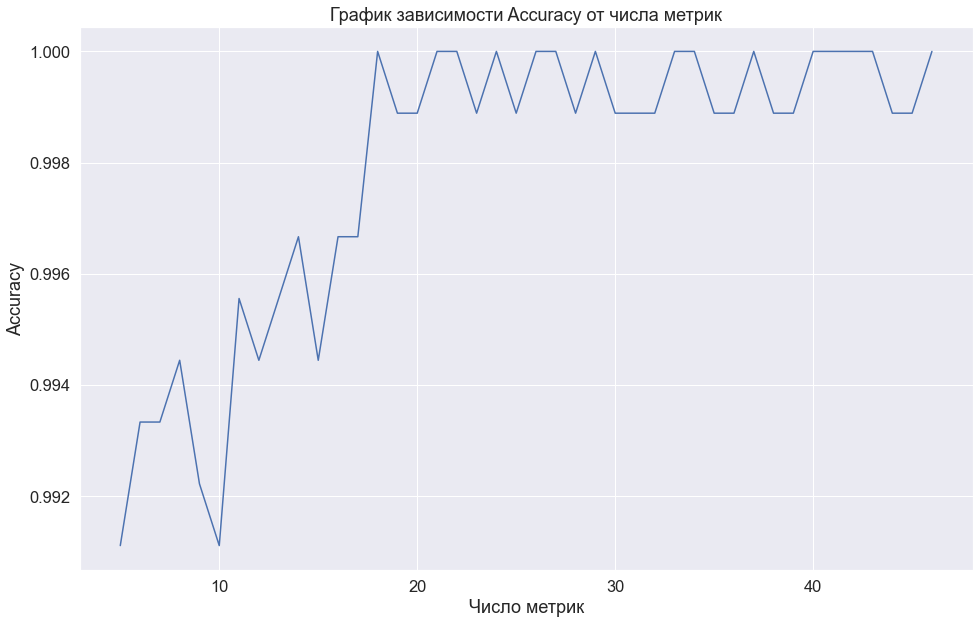

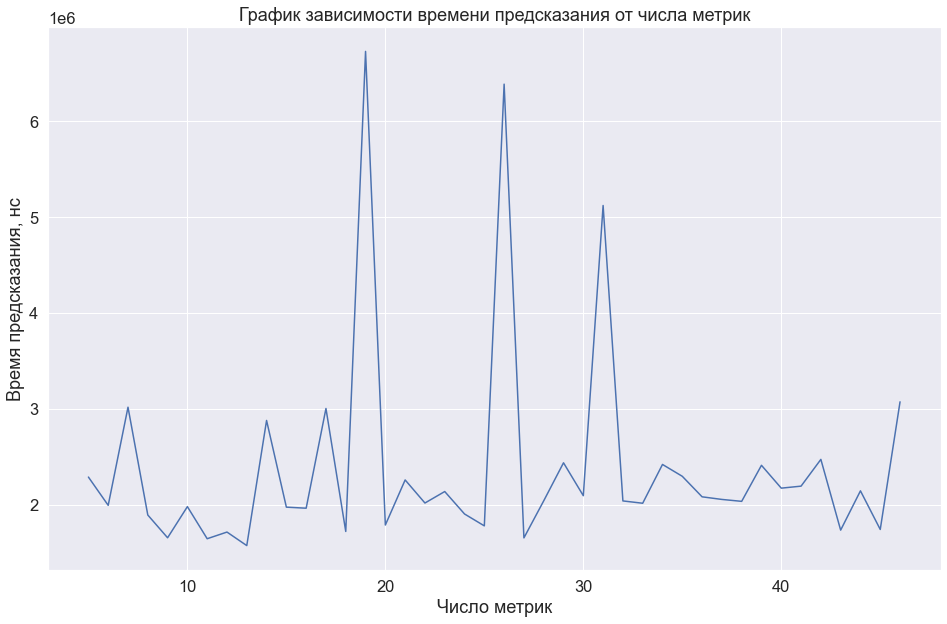

In [37]:
plt.figure(figsize=(16, 10))
plt.plot(
    np.arange(5, len(sorted_metrics)),
    history['accuracy']
)
plt.title("График зависимости Accuracy от числа метрик")
plt.xlabel("Число метрик")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(
    np.arange(5, len(sorted_metrics)),
    history['time_predict']
)
plt.title("График зависимости времени предсказания от числа метрик")
plt.xlabel("Число метрик")
plt.ylabel("Время предсказания, нс")
plt.show()

### Определение осанки для ходячего положения

In [4]:
data = pd.read_csv('../datasets/added_pos1_metrics_windowed.csv', index_col=[0, 1])

In [5]:
# data = data[data.columns[:23]]

In [6]:
data = data.droplevel(0)

In [7]:
data = data[data['position'] == 3].drop(['position', 'age'], axis=1)

In [8]:
data.head()

,x_mean,x_std,x_max,x_min,x_energy,x_iqr,y_mean,y_std,y_max,y_min,...,x_iqr_pos1,y_iqr_pos1,z_iqr_pos1,xy_corr_pos1,xz_corr_pos1,yz_corr_pos1,height,mass,is_valid,sex
level_1,,,,,,,,,,,,,,,,,,,,,
3621,12685.04,2477.023409,22084.0,6396.0,1.669845e+08,3433.0,1969.00,3074.250090,12488.0,-3760.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
3646,12148.96,2494.978107,22084.0,6396.0,1.537599e+08,2141.0,1951.48,3311.899216,12488.0,-3760.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
3671,12151.88,3207.290657,25876.0,6396.0,1.578520e+08,2697.0,1784.28,3319.946075,12488.0,-5016.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
3696,12398.36,3620.581932,29072.0,6396.0,1.666969e+08,3260.0,753.16,2951.146042,10968.0,-5704.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
3721,12812.64,3791.848513,29072.0,8804.0,1.783981e+08,3707.0,97.68,2808.045249,8604.0,-5844.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1


In [9]:
y = data['is_valid']
X = data.drop('is_valid', axis=1)

In [10]:
cat_feature = [X.columns.get_loc('sex')]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=1234
)

train_pool = Pool(X_train, label=y_train, cat_features=cat_feature, 
                  feature_names=list(X_train.columns))
test_pool = Pool(X_test, label=y_test, cat_features=cat_feature, 
                 feature_names=list(X_test.columns))

In [12]:
model = CatBoostClassifier(random_seed=0)

In [13]:
results = model.grid_search(
    param_grid={
        'n_estimators': [100, 200, 300, 500],
        'max_depth' : np.arange(2, 7),
        'learning_rate': np.linspace(0.0125, 0.6, 10)
    },
    X=train_pool,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.3640810233
bestIteration = 99

0:	loss: 0.3640810	best: 0.3640810 (0)	total: 181ms	remaining: 36.1s

bestTest = 0.1712543228
bestIteration = 99

1:	loss: 0.1712543	best: 0.1712543 (1)	total: 262ms	remaining: 26s

bestTest = 0.09323662125
bestIteration = 99

2:	loss: 0.0932366	best: 0.0932366 (2)	total: 345ms	remaining: 22.7s

bestTest = 0.05450230504
bestIteration = 99

3:	loss: 0.0545023	best: 0.0545023 (3)	total: 470ms	remaining: 23s

bestTest = 0.03050060947
bestIteration = 97

4:	loss: 0.0305006	best: 0.0305006 (4)	total: 555ms	remaining: 21.6s

bestTest = 0.02976250952
bestIteration = 98

5:	loss: 0.0297625	best: 0.0297625 (5)	total: 634ms	remaining: 20.5s

bestTest = 0.02635320611
bestIteration = 97

6:	loss: 0.0263532	best: 0.0263532 (6)	total: 717ms	remaining: 19.8s

bestTest = 0.02104792589
bestIteration = 99

7:	loss: 0.0210479	best: 0.0210479 (7)	total: 831ms	remaining: 19.9s

bestTest = 0.01683568953
bestIteration = 99

8:	loss: 0.0168357	best: 0.0168357 (8)	t


bestTest = 0.009576583166
bestIteration = 491

71:	loss: 0.0095766	best: 0.0049698 (66)	total: 19s	remaining: 33.8s

bestTest = 0.009918097837
bestIteration = 454

72:	loss: 0.0099181	best: 0.0049698 (66)	total: 19.6s	remaining: 34.1s

bestTest = 0.007982699984
bestIteration = 355

73:	loss: 0.0079827	best: 0.0049698 (66)	total: 20.1s	remaining: 34.1s

bestTest = 0.007657343729
bestIteration = 450

74:	loss: 0.0076573	best: 0.0049698 (66)	total: 20.6s	remaining: 34.3s

bestTest = 0.006523862583
bestIteration = 495

75:	loss: 0.0065239	best: 0.0049698 (66)	total: 21.1s	remaining: 34.5s

bestTest = 0.004969784006
bestIteration = 271

76:	loss: 0.0049698	best: 0.0049698 (66)	total: 21.8s	remaining: 34.8s

bestTest = 0.01889905212
bestIteration = 50

77:	loss: 0.0188991	best: 0.0049698 (66)	total: 22.4s	remaining: 35s

bestTest = 0.00736571874
bestIteration = 499

78:	loss: 0.0073657	best: 0.0049698 (66)	total: 23.1s	remaining: 35.4s

bestTest = 0.01361539324
bestIteration = 406

79:	loss


bestTest = 0.005004759455
bestIteration = 293

141:	loss: 0.0050048	best: 0.0042501 (114)	total: 47.7s	remaining: 19.5s

bestTest = 0.004142568412
bestIteration = 289

142:	loss: 0.0041426	best: 0.0041426 (142)	total: 48.8s	remaining: 19.5s

bestTest = 0.006424564706
bestIteration = 299

143:	loss: 0.0064246	best: 0.0041426 (142)	total: 49.4s	remaining: 19.2s

bestTest = 0.005536037985
bestIteration = 299

144:	loss: 0.0055360	best: 0.0041426 (142)	total: 49.9s	remaining: 18.9s

bestTest = 0.007371837215
bestIteration = 183

145:	loss: 0.0073718	best: 0.0041426 (142)	total: 50.4s	remaining: 18.7s

bestTest = 0.005531433979
bestIteration = 224

146:	loss: 0.0055314	best: 0.0041426 (142)	total: 51.1s	remaining: 18.4s

bestTest = 0.005773753902
bestIteration = 271

147:	loss: 0.0057738	best: 0.0041426 (142)	total: 51.8s	remaining: 18.2s

bestTest = 0.004931662185
bestIteration = 299

148:	loss: 0.0049317	best: 0.0041426 (142)	total: 52.5s	remaining: 18s

bestTest = 0.006714383099
bestIte

In [14]:
best_params = results['params']
best_params

{'depth': 6, 'iterations': 500, 'learning_rate': 0.27361111111111114}

In [19]:
best_model = CatBoostClassifier(use_best_model=True, random_seed=0, 
                           **best_params
                          )

best_model.fit(train_pool, eval_set=test_pool, metric_period=100)

0:	learn: 0.4113804	test: 0.4363481	best: 0.4363481 (0)	total: 3.37ms	remaining: 1.68s
100:	learn: 0.0017149	test: 0.0057587	best: 0.0057587 (100)	total: 269ms	remaining: 1.06s
200:	learn: 0.0015218	test: 0.0053313	best: 0.0053313 (200)	total: 453ms	remaining: 674ms
300:	learn: 0.0014770	test: 0.0052122	best: 0.0052122 (300)	total: 678ms	remaining: 448ms
400:	learn: 0.0014751	test: 0.0052052	best: 0.0052052 (400)	total: 867ms	remaining: 214ms
499:	learn: 0.0014733	test: 0.0051991	best: 0.0051991 (499)	total: 1.11s	remaining: 0us

bestTest = 0.005199075042
bestIteration = 499



In [20]:
best_model.save_model('CatBoostModel.cbm', format="cbm")

In [21]:
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       450
           1       1.00      1.00      1.00       450

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



In [22]:
for value, name in sorted(
    zip(model.get_feature_importance(fstr_type="FeatureImportance"), 
        X_train.columns), 
    reverse=True
):
    print("{}\t{:.2f}".format(name, value))

z_mean	19.37
y_mean	12.86
x_energy	7.14
z_max_pos1	5.02
z_min	4.64
xz_corr_pos1	3.97
z_energy_pos1	3.84
y_std_pos1	3.56
sma_pos1	3.40
z_energy	3.06
z_iqr_pos1	2.90
x_max_pos1	2.86
y_min_pos1	2.74
y_min	2.71
y_iqr_pos1	2.28
x_mean	2.26
z_std	1.86
xz_corr	1.70
yz_corr_pos1	1.46
z_mean_pos1	1.34
y_max_pos1	1.30
x_energy_pos1	0.95
x_std_pos1	0.79
x_min_pos1	0.70
x_iqr	0.68
x_max	0.68
x_iqr_pos1	0.62
y_energy	0.60
x_std	0.57
mass	0.53
y_iqr	0.51
z_max	0.40
y_mean_pos1	0.39
xy_corr	0.38
y_std	0.35
xy_corr_pos1	0.35
z_iqr	0.31
z_min_pos1	0.29
height	0.22
z_std_pos1	0.14
x_min	0.13
y_max	0.09
sma	0.06
yz_corr	0.00
y_energy_pos1	0.00
x_mean_pos1	0.00
sex	0.00


In [23]:
sorted_metrics = []

for value, name in sorted(
    zip(best_model.get_feature_importance(fstr_type="FeatureImportance"), 
        X_train.columns), 
    reverse=True
):
    sorted_metrics.append(name)
    print("{}\t{:.2f}".format(name, value))

z_mean	19.37
y_mean	12.86
x_energy	7.14
z_max_pos1	5.02
z_min	4.64
xz_corr_pos1	3.97
z_energy_pos1	3.84
y_std_pos1	3.56
sma_pos1	3.40
z_energy	3.06
z_iqr_pos1	2.90
x_max_pos1	2.86
y_min_pos1	2.74
y_min	2.71
y_iqr_pos1	2.28
x_mean	2.26
z_std	1.86
xz_corr	1.70
yz_corr_pos1	1.46
z_mean_pos1	1.34
y_max_pos1	1.30
x_energy_pos1	0.95
x_std_pos1	0.79
x_min_pos1	0.70
x_iqr	0.68
x_max	0.68
x_iqr_pos1	0.62
y_energy	0.60
x_std	0.57
mass	0.53
y_iqr	0.51
z_max	0.40
y_mean_pos1	0.39
xy_corr	0.38
y_std	0.35
xy_corr_pos1	0.35
z_iqr	0.31
z_min_pos1	0.29
height	0.22
z_std_pos1	0.14
x_min	0.13
y_max	0.09
sma	0.06
yz_corr	0.00
y_energy_pos1	0.00
x_mean_pos1	0.00
sex	0.00


In [24]:
from collections import defaultdict
from collections import OrderedDict

import time

In [29]:
history = defaultdict(list)

params_grid = {
            'n_estimators': [100, 200, 300, 500],
            'max_depth' : np.arange(3, 7),
            'learning_rate': np.linspace(0.0125, 0.6, 10)
        }

In [30]:
for i in tqdm(range(5, len(sorted_metrics))):
    metrics = sorted_metrics[:i]
    
    model = getBestModelCB(X_train[metrics], X_test[metrics], y_train, y_test,
                        params_grid=params_grid)
    
    start_time = time.time_ns()
    y_pred = model.predict(X_test)
    history['time_predict'].append(time.time_ns() - start_time)
    
    accuracy = accuracy_score(y_test, y_pred)
    history['accuracy'].append(accuracy)

  0%|          | 0/42 [00:00<?, ?it/s]

0:	learn: 0.4009513	test: 0.4100407	best: 0.4100407 (0)	total: 1.39ms	remaining: 693ms
100:	learn: 0.0053945	test: 0.0164341	best: 0.0164341 (100)	total: 101ms	remaining: 398ms
200:	learn: 0.0036562	test: 0.0149474	best: 0.0149474 (200)	total: 197ms	remaining: 293ms
300:	learn: 0.0028205	test: 0.0141842	best: 0.0141842 (300)	total: 339ms	remaining: 224ms
400:	learn: 0.0025854	test: 0.0139893	best: 0.0139893 (400)	total: 439ms	remaining: 108ms


  2%|▏         | 1/42 [01:03<43:23, 63.49s/it]

499:	learn: 0.0025367	test: 0.0141616	best: 0.0139893 (400)	total: 537ms	remaining: 0us

bestTest = 0.01398928222
bestIteration = 400

Shrink model to first 401 iterations.
0:	learn: 0.3029926	test: 0.3359685	best: 0.3359685 (0)	total: 3.96ms	remaining: 1.98s
100:	learn: 0.0012269	test: 0.0143635	best: 0.0143635 (100)	total: 170ms	remaining: 671ms
200:	learn: 0.0011122	test: 0.0141326	best: 0.0141326 (200)	total: 304ms	remaining: 452ms
300:	learn: 0.0011088	test: 0.0141411	best: 0.0141326 (200)	total: 400ms	remaining: 265ms
400:	learn: 0.0011047	test: 0.0141452	best: 0.0141326 (200)	total: 496ms	remaining: 123ms


  5%|▍         | 2/42 [02:02<40:39, 60.99s/it]

499:	learn: 0.0010990	test: 0.0141440	best: 0.0141326 (200)	total: 631ms	remaining: 0us

bestTest = 0.01413262917
bestIteration = 200

Shrink model to first 201 iterations.
0:	learn: 0.3636050	test: 0.3747226	best: 0.3747226 (0)	total: 1.56ms	remaining: 779ms
100:	learn: 0.0013660	test: 0.0176950	best: 0.0176950 (100)	total: 197ms	remaining: 778ms
200:	learn: 0.0012450	test: 0.0179822	best: 0.0176950 (100)	total: 345ms	remaining: 513ms
300:	learn: 0.0011846	test: 0.0185041	best: 0.0176950 (100)	total: 443ms	remaining: 293ms


  7%|▋         | 3/42 [03:03<39:27, 60.70s/it]

400:	learn: 0.0011773	test: 0.0185458	best: 0.0176950 (100)	total: 593ms	remaining: 146ms
499:	learn: 0.0011713	test: 0.0185601	best: 0.0176950 (100)	total: 689ms	remaining: 0us

bestTest = 0.01769499067
bestIteration = 100

Shrink model to first 101 iterations.
0:	learn: 0.2804103	test: 0.3021782	best: 0.3021782 (0)	total: 4.72ms	remaining: 2.36s
100:	learn: 0.0012724	test: 0.0134931	best: 0.0134931 (100)	total: 150ms	remaining: 593ms
200:	learn: 0.0011586	test: 0.0132249	best: 0.0132249 (200)	total: 288ms	remaining: 428ms
300:	learn: 0.0010424	test: 0.0134834	best: 0.0132249 (200)	total: 383ms	remaining: 253ms


 10%|▉         | 4/42 [04:02<38:03, 60.08s/it]

400:	learn: 0.0010368	test: 0.0134635	best: 0.0132249 (200)	total: 486ms	remaining: 120ms
499:	learn: 0.0010315	test: 0.0134435	best: 0.0132249 (200)	total: 599ms	remaining: 0us

bestTest = 0.01322493311
bestIteration = 200

Shrink model to first 201 iterations.
0:	learn: 0.2570309	test: 0.2685231	best: 0.2685231 (0)	total: 1.32ms	remaining: 395ms
100:	learn: 0.0014194	test: 0.0098723	best: 0.0098723 (100)	total: 102ms	remaining: 201ms


 12%|█▏        | 5/42 [04:53<35:02, 56.82s/it]

200:	learn: 0.0014123	test: 0.0098268	best: 0.0098268 (200)	total: 213ms	remaining: 105ms
299:	learn: 0.0010942	test: 0.0103751	best: 0.0098268 (200)	total: 349ms	remaining: 0us

bestTest = 0.00982675575
bestIteration = 200

Shrink model to first 201 iterations.
0:	learn: 0.4739203	test: 0.4779115	best: 0.4779115 (0)	total: 5.5ms	remaining: 2.74s
100:	learn: 0.0020515	test: 0.0143546	best: 0.0143546 (100)	total: 146ms	remaining: 578ms
200:	learn: 0.0014540	test: 0.0146792	best: 0.0143546 (100)	total: 282ms	remaining: 420ms
300:	learn: 0.0014528	test: 0.0146845	best: 0.0143546 (100)	total: 380ms	remaining: 251ms


 14%|█▍        | 6/42 [05:55<35:12, 58.68s/it]

400:	learn: 0.0014332	test: 0.0147456	best: 0.0143546 (100)	total: 479ms	remaining: 118ms
499:	learn: 0.0014322	test: 0.0147514	best: 0.0143546 (100)	total: 611ms	remaining: 0us

bestTest = 0.01435457188
bestIteration = 100

Shrink model to first 101 iterations.
0:	learn: 0.3688677	test: 0.3796556	best: 0.3796556 (0)	total: 1.08ms	remaining: 539ms
100:	learn: 0.0015467	test: 0.0120047	best: 0.0120047 (100)	total: 92.1ms	remaining: 364ms
200:	learn: 0.0014240	test: 0.0121290	best: 0.0120047 (100)	total: 174ms	remaining: 259ms


 17%|█▋        | 7/42 [06:55<34:25, 59.02s/it]

300:	learn: 0.0013706	test: 0.0121431	best: 0.0120047 (100)	total: 299ms	remaining: 198ms
400:	learn: 0.0013592	test: 0.0121643	best: 0.0120047 (100)	total: 380ms	remaining: 93.9ms
499:	learn: 0.0013395	test: 0.0121678	best: 0.0120047 (100)	total: 461ms	remaining: 0us

bestTest = 0.01200469759
bestIteration = 100

Shrink model to first 101 iterations.
0:	learn: 0.4015008	test: 0.4158377	best: 0.4158377 (0)	total: 5.33ms	remaining: 2.66s
100:	learn: 0.0018776	test: 0.0147349	best: 0.0147349 (100)	total: 145ms	remaining: 574ms
200:	learn: 0.0016281	test: 0.0139839	best: 0.0139839 (200)	total: 297ms	remaining: 442ms
300:	learn: 0.0016237	test: 0.0139827	best: 0.0139827 (300)	total: 401ms	remaining: 265ms


 19%|█▉        | 8/42 [07:56<33:52, 59.78s/it]

400:	learn: 0.0015526	test: 0.0139758	best: 0.0139758 (400)	total: 506ms	remaining: 125ms
499:	learn: 0.0015425	test: 0.0140100	best: 0.0139758 (400)	total: 620ms	remaining: 0us

bestTest = 0.0139758423
bestIteration = 400

Shrink model to first 401 iterations.
0:	learn: 0.4182818	test: 0.4263266	best: 0.4263266 (0)	total: 1.34ms	remaining: 670ms
100:	learn: 0.0015812	test: 0.0146270	best: 0.0146270 (100)	total: 105ms	remaining: 414ms
200:	learn: 0.0015689	test: 0.0145777	best: 0.0145777 (200)	total: 206ms	remaining: 306ms
300:	learn: 0.0015654	test: 0.0145731	best: 0.0145731 (300)	total: 364ms	remaining: 241ms


 21%|██▏       | 9/42 [08:57<33:01, 60.04s/it]

400:	learn: 0.0015624	test: 0.0145719	best: 0.0145719 (400)	total: 472ms	remaining: 117ms
499:	learn: 0.0015397	test: 0.0145317	best: 0.0145317 (499)	total: 570ms	remaining: 0us

bestTest = 0.01453171595
bestIteration = 499

0:	learn: 0.3147868	test: 0.3438330	best: 0.3438330 (0)	total: 4.39ms	remaining: 2.19s
100:	learn: 0.0015987	test: 0.0117437	best: 0.0117437 (100)	total: 136ms	remaining: 539ms
200:	learn: 0.0015961	test: 0.0117470	best: 0.0117437 (100)	total: 251ms	remaining: 373ms
300:	learn: 0.0015930	test: 0.0117520	best: 0.0117437 (100)	total: 361ms	remaining: 239ms


 24%|██▍       | 10/42 [09:59<32:23, 60.74s/it]

400:	learn: 0.0014083	test: 0.0112641	best: 0.0112641 (400)	total: 475ms	remaining: 117ms
499:	learn: 0.0014076	test: 0.0112669	best: 0.0112641 (400)	total: 579ms	remaining: 0us

bestTest = 0.01126410771
bestIteration = 400

Shrink model to first 401 iterations.
0:	learn: 0.2837220	test: 0.3282875	best: 0.3282875 (0)	total: 1.14ms	remaining: 567ms
100:	learn: 0.0029600	test: 0.0188412	best: 0.0188412 (100)	total: 88.6ms	remaining: 350ms
200:	learn: 0.0029276	test: 0.0188922	best: 0.0188412 (100)	total: 174ms	remaining: 259ms


 26%|██▌       | 11/42 [11:02<31:47, 61.54s/it]

300:	learn: 0.0011311	test: 0.0160102	best: 0.0160102 (300)	total: 274ms	remaining: 181ms
400:	learn: 0.0011192	test: 0.0160090	best: 0.0160090 (400)	total: 360ms	remaining: 89ms
499:	learn: 0.0010621	test: 0.0164456	best: 0.0160090 (400)	total: 445ms	remaining: 0us

bestTest = 0.01600898883
bestIteration = 400

Shrink model to first 401 iterations.
0:	learn: 0.4040715	test: 0.4135520	best: 0.4135520 (0)	total: 1.35ms	remaining: 675ms
100:	learn: 0.0016053	test: 0.0156061	best: 0.0156061 (100)	total: 116ms	remaining: 460ms
200:	learn: 0.0013520	test: 0.0150557	best: 0.0150557 (200)	total: 246ms	remaining: 367ms
300:	learn: 0.0012791	test: 0.0148104	best: 0.0148104 (300)	total: 369ms	remaining: 244ms


 29%|██▊       | 12/42 [12:07<31:15, 62.52s/it]

400:	learn: 0.0012398	test: 0.0148154	best: 0.0148104 (300)	total: 491ms	remaining: 121ms
499:	learn: 0.0012364	test: 0.0148154	best: 0.0148104 (300)	total: 602ms	remaining: 0us

bestTest = 0.01481043332
bestIteration = 300

Shrink model to first 301 iterations.
0:	learn: 0.4702781	test: 0.4758190	best: 0.4758190 (0)	total: 2.73ms	remaining: 1.36s
100:	learn: 0.0023136	test: 0.0115289	best: 0.0115289 (100)	total: 370ms	remaining: 1.46s
200:	learn: 0.0020149	test: 0.0113982	best: 0.0113982 (200)	total: 705ms	remaining: 1.05s
300:	learn: 0.0020111	test: 0.0114210	best: 0.0113982 (200)	total: 884ms	remaining: 584ms


 31%|███       | 13/42 [13:14<30:52, 63.89s/it]

400:	learn: 0.0019432	test: 0.0113367	best: 0.0113367 (400)	total: 1.04s	remaining: 257ms
499:	learn: 0.0018548	test: 0.0111705	best: 0.0111705 (499)	total: 1.17s	remaining: 0us

bestTest = 0.01117045339
bestIteration = 499

0:	learn: 0.3108719	test: 0.3403097	best: 0.3403097 (0)	total: 1.26ms	remaining: 629ms
100:	learn: 0.0017038	test: 0.0107245	best: 0.0107245 (100)	total: 101ms	remaining: 400ms
200:	learn: 0.0016921	test: 0.0106826	best: 0.0106826 (200)	total: 203ms	remaining: 302ms
300:	learn: 0.0014661	test: 0.0100384	best: 0.0100384 (300)	total: 335ms	remaining: 221ms


 33%|███▎      | 14/42 [14:26<30:53, 66.19s/it]

400:	learn: 0.0014646	test: 0.0100192	best: 0.0100192 (400)	total: 453ms	remaining: 112ms
499:	learn: 0.0014607	test: 0.0100044	best: 0.0100044 (499)	total: 573ms	remaining: 0us

bestTest = 0.01000444786
bestIteration = 499

0:	learn: 0.3232967	test: 0.3392789	best: 0.3392789 (0)	total: 2.23ms	remaining: 1.11s
100:	learn: 0.0013284	test: 0.0101292	best: 0.0101292 (100)	total: 328ms	remaining: 1.3s
200:	learn: 0.0012850	test: 0.0097540	best: 0.0097540 (200)	total: 555ms	remaining: 826ms
300:	learn: 0.0012023	test: 0.0096643	best: 0.0096643 (300)	total: 744ms	remaining: 492ms
400:	learn: 0.0011447	test: 0.0095056	best: 0.0095056 (400)	total: 914ms	remaining: 226ms
499:	learn: 0.0011405	test: 0.0094955	best: 0.0094955 (499)	total: 1.11s	remaining: 0us

bestTest = 0.009495515655
bestIteration = 499



 36%|███▌      | 15/42 [15:45<31:29, 69.99s/it]

0:	learn: 0.5726210	test: 0.5731624	best: 0.5731624 (0)	total: 2.17ms	remaining: 1.08s
100:	learn: 0.0050611	test: 0.0107594	best: 0.0107594 (100)	total: 141ms	remaining: 558ms
200:	learn: 0.0022213	test: 0.0066241	best: 0.0066241 (200)	total: 286ms	remaining: 426ms
300:	learn: 0.0018834	test: 0.0061006	best: 0.0061006 (300)	total: 420ms	remaining: 277ms


 38%|███▊      | 16/42 [17:02<31:15, 72.12s/it]

400:	learn: 0.0017828	test: 0.0059795	best: 0.0059795 (400)	total: 573ms	remaining: 141ms
499:	learn: 0.0016633	test: 0.0057291	best: 0.0057291 (499)	total: 709ms	remaining: 0us

bestTest = 0.005729064884
bestIteration = 499

0:	learn: 0.2674347	test: 0.2934837	best: 0.2934837 (0)	total: 1.58ms	remaining: 789ms
100:	learn: 0.0014352	test: 0.0063782	best: 0.0063782 (100)	total: 161ms	remaining: 636ms
200:	learn: 0.0009719	test: 0.0055123	best: 0.0055123 (200)	total: 369ms	remaining: 549ms
300:	learn: 0.0009639	test: 0.0055007	best: 0.0055007 (300)	total: 531ms	remaining: 351ms


 40%|████      | 17/42 [18:20<30:52, 74.11s/it]

400:	learn: 0.0009595	test: 0.0054861	best: 0.0054861 (400)	total: 697ms	remaining: 172ms
499:	learn: 0.0009548	test: 0.0054727	best: 0.0054727 (499)	total: 849ms	remaining: 0us

bestTest = 0.00547267706
bestIteration = 499

0:	learn: 0.3413116	test: 0.3502539	best: 0.3502539 (0)	total: 1.62ms	remaining: 807ms
100:	learn: 0.0014251	test: 0.0065952	best: 0.0065952 (100)	total: 145ms	remaining: 572ms
200:	learn: 0.0013052	test: 0.0061599	best: 0.0061599 (200)	total: 307ms	remaining: 457ms
300:	learn: 0.0013025	test: 0.0061538	best: 0.0061538 (300)	total: 462ms	remaining: 306ms


 43%|████▎     | 18/42 [19:34<29:35, 74.00s/it]

400:	learn: 0.0012980	test: 0.0061493	best: 0.0061493 (400)	total: 637ms	remaining: 157ms
499:	learn: 0.0012922	test: 0.0061376	best: 0.0061376 (499)	total: 803ms	remaining: 0us

bestTest = 0.006137588999
bestIteration = 499

0:	learn: 0.2780563	test: 0.2942560	best: 0.2942560 (0)	total: 1.59ms	remaining: 793ms
100:	learn: 0.0013433	test: 0.0066931	best: 0.0066931 (100)	total: 132ms	remaining: 523ms
200:	learn: 0.0012797	test: 0.0064427	best: 0.0064427 (200)	total: 271ms	remaining: 403ms
300:	learn: 0.0012748	test: 0.0064384	best: 0.0064384 (300)	total: 422ms	remaining: 279ms


 45%|████▌     | 19/42 [20:54<29:01, 75.74s/it]

400:	learn: 0.0012688	test: 0.0064312	best: 0.0064312 (400)	total: 564ms	remaining: 139ms
499:	learn: 0.0012629	test: 0.0064256	best: 0.0064256 (499)	total: 692ms	remaining: 0us

bestTest = 0.006425629114
bestIteration = 499

0:	learn: 0.3435496	test: 0.3638296	best: 0.3638296 (0)	total: 5.12ms	remaining: 2.55s
100:	learn: 0.0016148	test: 0.0050888	best: 0.0050888 (100)	total: 230ms	remaining: 908ms
200:	learn: 0.0013661	test: 0.0045309	best: 0.0045309 (200)	total: 358ms	remaining: 533ms
300:	learn: 0.0013633	test: 0.0045224	best: 0.0045224 (300)	total: 507ms	remaining: 335ms
400:	learn: 0.0013605	test: 0.0045137	best: 0.0045137 (400)	total: 651ms	remaining: 161ms


 48%|████▊     | 20/42 [22:11<27:55, 76.17s/it]

499:	learn: 0.0013308	test: 0.0044212	best: 0.0044212 (499)	total: 790ms	remaining: 0us

bestTest = 0.004421157897
bestIteration = 499

0:	learn: 0.5086082	test: 0.5127395	best: 0.5127395 (0)	total: 1.58ms	remaining: 791ms
100:	learn: 0.0020794	test: 0.0060400	best: 0.0060400 (100)	total: 164ms	remaining: 649ms
200:	learn: 0.0019977	test: 0.0057966	best: 0.0057966 (200)	total: 324ms	remaining: 482ms
300:	learn: 0.0018266	test: 0.0055325	best: 0.0055325 (300)	total: 470ms	remaining: 311ms


 50%|█████     | 21/42 [23:28<26:44, 76.43s/it]

400:	learn: 0.0018241	test: 0.0055255	best: 0.0055255 (400)	total: 622ms	remaining: 154ms
499:	learn: 0.0018213	test: 0.0055182	best: 0.0055182 (499)	total: 757ms	remaining: 0us

bestTest = 0.005518246338
bestIteration = 499

0:	learn: 0.3198540	test: 0.3465677	best: 0.3465677 (0)	total: 1.47ms	remaining: 733ms
100:	learn: 0.0020963	test: 0.0062848	best: 0.0062848 (100)	total: 115ms	remaining: 452ms
200:	learn: 0.0017222	test: 0.0051695	best: 0.0051695 (200)	total: 234ms	remaining: 349ms
300:	learn: 0.0016258	test: 0.0050841	best: 0.0050841 (300)	total: 346ms	remaining: 229ms


 52%|█████▏    | 22/42 [24:44<25:28, 76.40s/it]

400:	learn: 0.0016139	test: 0.0050666	best: 0.0050666 (400)	total: 464ms	remaining: 115ms
499:	learn: 0.0013793	test: 0.0045274	best: 0.0045274 (499)	total: 573ms	remaining: 0us

bestTest = 0.004527403509
bestIteration = 499

0:	learn: 0.2933106	test: 0.3131636	best: 0.3131636 (0)	total: 1.78ms	remaining: 887ms
100:	learn: 0.0014736	test: 0.0095733	best: 0.0095733 (100)	total: 149ms	remaining: 588ms
200:	learn: 0.0014672	test: 0.0095427	best: 0.0095427 (200)	total: 302ms	remaining: 449ms
300:	learn: 0.0014608	test: 0.0095129	best: 0.0095129 (300)	total: 443ms	remaining: 293ms


 55%|█████▍    | 23/42 [26:03<24:24, 77.11s/it]

400:	learn: 0.0012569	test: 0.0084383	best: 0.0084383 (400)	total: 594ms	remaining: 147ms
499:	learn: 0.0012515	test: 0.0084289	best: 0.0084289 (499)	total: 739ms	remaining: 0us

bestTest = 0.008428899896
bestIteration = 499

0:	learn: 0.2633955	test: 0.2754584	best: 0.2754584 (0)	total: 4.4ms	remaining: 2.2s
100:	learn: 0.0032926	test: 0.0116539	best: 0.0116539 (100)	total: 140ms	remaining: 555ms
200:	learn: 0.0032926	test: 0.0116539	best: 0.0116539 (100)	total: 261ms	remaining: 388ms
300:	learn: 0.0032926	test: 0.0116539	best: 0.0116539 (100)	total: 368ms	remaining: 243ms


 57%|█████▋    | 24/42 [27:17<22:51, 76.18s/it]

400:	learn: 0.0030951	test: 0.0114905	best: 0.0114905 (400)	total: 486ms	remaining: 120ms
499:	learn: 0.0011358	test: 0.0066606	best: 0.0066606 (499)	total: 599ms	remaining: 0us

bestTest = 0.006660601904
bestIteration = 499

0:	learn: 0.3714294	test: 0.3833053	best: 0.3833053 (0)	total: 4.14ms	remaining: 2.06s
100:	learn: 0.0025230	test: 0.0058689	best: 0.0058689 (100)	total: 207ms	remaining: 816ms
200:	learn: 0.0025222	test: 0.0058698	best: 0.0058689 (100)	total: 363ms	remaining: 540ms
300:	learn: 0.0015137	test: 0.0039655	best: 0.0039655 (300)	total: 541ms	remaining: 357ms
400:	learn: 0.0015100	test: 0.0039700	best: 0.0039655 (300)	total: 701ms	remaining: 173ms


 60%|█████▉    | 25/42 [28:36<21:50, 77.10s/it]

499:	learn: 0.0015065	test: 0.0039736	best: 0.0039655 (300)	total: 904ms	remaining: 0us

bestTest = 0.003965522026
bestIteration = 300

Shrink model to first 301 iterations.
0:	learn: 0.4855332	test: 0.4965605	best: 0.4965605 (0)	total: 1.78ms	remaining: 888ms
100:	learn: 0.0024295	test: 0.0073147	best: 0.0073147 (100)	total: 176ms	remaining: 696ms
200:	learn: 0.0015601	test: 0.0055424	best: 0.0055424 (200)	total: 345ms	remaining: 514ms
300:	learn: 0.0014905	test: 0.0054344	best: 0.0054344 (300)	total: 497ms	remaining: 329ms


 62%|██████▏   | 26/42 [30:01<21:07, 79.24s/it]

400:	learn: 0.0014413	test: 0.0052980	best: 0.0052980 (400)	total: 667ms	remaining: 165ms
499:	learn: 0.0014376	test: 0.0052891	best: 0.0052891 (499)	total: 825ms	remaining: 0us

bestTest = 0.005289096188
bestIteration = 499

0:	learn: 0.2418454	test: 0.2887394	best: 0.2887394 (0)	total: 1.75ms	remaining: 874ms
100:	learn: 0.0015476	test: 0.0079757	best: 0.0079757 (100)	total: 148ms	remaining: 583ms
200:	learn: 0.0014752	test: 0.0079454	best: 0.0079454 (200)	total: 333ms	remaining: 495ms
300:	learn: 0.0011359	test: 0.0068567	best: 0.0068567 (300)	total: 480ms	remaining: 317ms


 64%|██████▍   | 27/42 [31:28<20:23, 81.55s/it]

400:	learn: 0.0011252	test: 0.0068096	best: 0.0068096 (400)	total: 643ms	remaining: 159ms
499:	learn: 0.0010876	test: 0.0065876	best: 0.0065876 (499)	total: 788ms	remaining: 0us

bestTest = 0.006587633727
bestIteration = 499

0:	learn: 0.2397352	test: 0.2613054	best: 0.2613054 (0)	total: 6.71ms	remaining: 2s
100:	learn: 0.0011957	test: 0.0169551	best: 0.0169551 (100)	total: 222ms	remaining: 438ms
200:	learn: 0.0011892	test: 0.0169146	best: 0.0169146 (200)	total: 386ms	remaining: 190ms


 67%|██████▋   | 28/42 [32:38<18:13, 78.12s/it]

299:	learn: 0.0011633	test: 0.0167380	best: 0.0167380 (299)	total: 551ms	remaining: 0us

bestTest = 0.01673800642
bestIteration = 299

0:	learn: 0.2106376	test: 0.2233087	best: 0.2233087 (0)	total: 1.82ms	remaining: 907ms
100:	learn: 0.0015344	test: 0.0073296	best: 0.0073296 (100)	total: 157ms	remaining: 619ms
200:	learn: 0.0013798	test: 0.0070855	best: 0.0070855 (200)	total: 325ms	remaining: 483ms
300:	learn: 0.0013513	test: 0.0070444	best: 0.0070444 (300)	total: 472ms	remaining: 312ms


 69%|██████▉   | 29/42 [33:58<17:05, 78.91s/it]

400:	learn: 0.0013186	test: 0.0070105	best: 0.0070105 (400)	total: 633ms	remaining: 156ms
499:	learn: 0.0013145	test: 0.0069979	best: 0.0069979 (499)	total: 779ms	remaining: 0us

bestTest = 0.006997881191
bestIteration = 499

0:	learn: 0.3817996	test: 0.3869378	best: 0.3869378 (0)	total: 1.83ms	remaining: 915ms
100:	learn: 0.0017438	test: 0.0048346	best: 0.0048346 (100)	total: 165ms	remaining: 652ms
200:	learn: 0.0016679	test: 0.0046791	best: 0.0046791 (200)	total: 337ms	remaining: 502ms
300:	learn: 0.0015032	test: 0.0042722	best: 0.0042722 (300)	total: 489ms	remaining: 323ms


 71%|███████▏  | 30/42 [35:21<15:59, 79.96s/it]

400:	learn: 0.0014386	test: 0.0040887	best: 0.0040887 (400)	total: 663ms	remaining: 164ms
499:	learn: 0.0013836	test: 0.0039464	best: 0.0039464 (499)	total: 824ms	remaining: 0us

bestTest = 0.003946432555
bestIteration = 499

0:	learn: 0.4045815	test: 0.4145924	best: 0.4145924 (0)	total: 7.4ms	remaining: 3.69s
100:	learn: 0.0020574	test: 0.0077802	best: 0.0077802 (100)	total: 239ms	remaining: 945ms
200:	learn: 0.0019832	test: 0.0076280	best: 0.0076280 (200)	total: 409ms	remaining: 608ms
300:	learn: 0.0018583	test: 0.0075071	best: 0.0075071 (300)	total: 597ms	remaining: 395ms
400:	learn: 0.0018556	test: 0.0075108	best: 0.0075071 (300)	total: 772ms	remaining: 191ms


 74%|███████▍  | 31/42 [36:47<14:59, 81.74s/it]

499:	learn: 0.0017831	test: 0.0072768	best: 0.0072768 (499)	total: 955ms	remaining: 0us

bestTest = 0.007276780535
bestIteration = 499

0:	learn: 0.3648448	test: 0.3965475	best: 0.3965475 (0)	total: 1.48ms	remaining: 738ms
100:	learn: 0.0016788	test: 0.0071915	best: 0.0071915 (100)	total: 126ms	remaining: 499ms
200:	learn: 0.0016342	test: 0.0069778	best: 0.0069778 (200)	total: 265ms	remaining: 394ms
300:	learn: 0.0016303	test: 0.0069827	best: 0.0069778 (200)	total: 420ms	remaining: 277ms


 76%|███████▌  | 32/42 [38:08<13:36, 81.64s/it]

400:	learn: 0.0016269	test: 0.0069897	best: 0.0069778 (200)	total: 559ms	remaining: 138ms
499:	learn: 0.0016233	test: 0.0069917	best: 0.0069778 (200)	total: 691ms	remaining: 0us

bestTest = 0.006977793285
bestIteration = 200

Shrink model to first 201 iterations.
0:	learn: 0.2971372	test: 0.3250831	best: 0.3250831 (0)	total: 4.47ms	remaining: 2.23s
100:	learn: 0.0015432	test: 0.0072183	best: 0.0072183 (100)	total: 196ms	remaining: 775ms
200:	learn: 0.0015386	test: 0.0072043	best: 0.0072043 (200)	total: 384ms	remaining: 571ms
300:	learn: 0.0014878	test: 0.0069811	best: 0.0069811 (300)	total: 554ms	remaining: 366ms


 79%|███████▊  | 33/42 [39:38<12:35, 83.97s/it]

400:	learn: 0.0014878	test: 0.0069811	best: 0.0069811 (300)	total: 741ms	remaining: 183ms
499:	learn: 0.0014878	test: 0.0069811	best: 0.0069811 (300)	total: 910ms	remaining: 0us

bestTest = 0.006981135299
bestIteration = 300

Shrink model to first 301 iterations.
0:	learn: 0.4188002	test: 0.4296888	best: 0.4296888 (0)	total: 7.63ms	remaining: 3.81s
100:	learn: 0.0021062	test: 0.0055308	best: 0.0055308 (100)	total: 233ms	remaining: 922ms
200:	learn: 0.0018275	test: 0.0050427	best: 0.0050427 (200)	total: 416ms	remaining: 619ms
300:	learn: 0.0017050	test: 0.0046948	best: 0.0046948 (300)	total: 613ms	remaining: 405ms
400:	learn: 0.0017009	test: 0.0046847	best: 0.0046847 (400)	total: 792ms	remaining: 195ms


 81%|████████  | 34/42 [41:06<11:22, 85.32s/it]

499:	learn: 0.0015771	test: 0.0044488	best: 0.0044488 (499)	total: 990ms	remaining: 0us

bestTest = 0.004448790511
bestIteration = 499

0:	learn: 0.5145662	test: 0.5211517	best: 0.5211517 (0)	total: 1.54ms	remaining: 771ms
100:	learn: 0.0035060	test: 0.0086473	best: 0.0086473 (100)	total: 137ms	remaining: 543ms
200:	learn: 0.0027305	test: 0.0075881	best: 0.0075881 (200)	total: 279ms	remaining: 415ms
300:	learn: 0.0025093	test: 0.0070857	best: 0.0070857 (300)	total: 405ms	remaining: 267ms


 83%|████████▎ | 35/42 [42:33<10:00, 85.78s/it]

400:	learn: 0.0023307	test: 0.0068261	best: 0.0068261 (400)	total: 549ms	remaining: 135ms
499:	learn: 0.0022377	test: 0.0067565	best: 0.0067565 (499)	total: 690ms	remaining: 0us

bestTest = 0.006756452054
bestIteration = 499

0:	learn: 0.4528320	test: 0.4642857	best: 0.4642857 (0)	total: 2.08ms	remaining: 1.03s
100:	learn: 0.0015348	test: 0.0065020	best: 0.0065020 (100)	total: 182ms	remaining: 721ms
200:	learn: 0.0012745	test: 0.0057429	best: 0.0057429 (200)	total: 380ms	remaining: 565ms
300:	learn: 0.0011810	test: 0.0054065	best: 0.0054065 (300)	total: 559ms	remaining: 370ms
400:	learn: 0.0011773	test: 0.0054008	best: 0.0054008 (400)	total: 753ms	remaining: 186ms
499:	learn: 0.0011745	test: 0.0053959	best: 0.0053959 (499)	total: 935ms	remaining: 0us

bestTest = 0.005395933766
bestIteration = 499



 86%|████████▌ | 36/42 [44:03<08:42, 87.06s/it]

0:	learn: 0.4597496	test: 0.4667057	best: 0.4667057 (0)	total: 2.09ms	remaining: 1.04s
100:	learn: 0.0024154	test: 0.0067783	best: 0.0067783 (100)	total: 191ms	remaining: 753ms
200:	learn: 0.0019854	test: 0.0059504	best: 0.0059504 (200)	total: 391ms	remaining: 581ms
300:	learn: 0.0019460	test: 0.0059251	best: 0.0059251 (300)	total: 579ms	remaining: 383ms


 88%|████████▊ | 37/42 [45:34<07:21, 88.29s/it]

400:	learn: 0.0018738	test: 0.0057536	best: 0.0057536 (400)	total: 784ms	remaining: 194ms
499:	learn: 0.0018696	test: 0.0057450	best: 0.0057450 (499)	total: 960ms	remaining: 0us

bestTest = 0.005745010588
bestIteration = 499

0:	learn: 0.3224336	test: 0.3338208	best: 0.3338208 (0)	total: 2.08ms	remaining: 1.04s
100:	learn: 0.0018583	test: 0.0057003	best: 0.0057003 (100)	total: 186ms	remaining: 734ms
200:	learn: 0.0017459	test: 0.0054755	best: 0.0054755 (200)	total: 393ms	remaining: 585ms
300:	learn: 0.0017409	test: 0.0054625	best: 0.0054625 (300)	total: 578ms	remaining: 382ms
400:	learn: 0.0017325	test: 0.0054396	best: 0.0054396 (400)	total: 785ms	remaining: 194ms
499:	learn: 0.0017258	test: 0.0054218	best: 0.0054218 (499)	total: 974ms	remaining: 0us

bestTest = 0.005421753575
bestIteration = 499



 90%|█████████ | 38/42 [47:07<05:58, 89.69s/it]

0:	learn: 0.3521430	test: 0.3792751	best: 0.3792751 (0)	total: 1.72ms	remaining: 859ms
100:	learn: 0.0031732	test: 0.0076686	best: 0.0076686 (100)	total: 144ms	remaining: 568ms
200:	learn: 0.0030402	test: 0.0075819	best: 0.0075819 (200)	total: 307ms	remaining: 457ms
300:	learn: 0.0028776	test: 0.0071321	best: 0.0071321 (300)	total: 443ms	remaining: 293ms


 93%|█████████▎| 39/42 [48:36<04:28, 89.55s/it]

400:	learn: 0.0028743	test: 0.0071378	best: 0.0071321 (300)	total: 604ms	remaining: 149ms
499:	learn: 0.0026733	test: 0.0068631	best: 0.0068631 (499)	total: 744ms	remaining: 0us

bestTest = 0.006863133529
bestIteration = 499

0:	learn: 0.3609047	test: 0.3807359	best: 0.3807359 (0)	total: 2.11ms	remaining: 1.05s
100:	learn: 0.0030449	test: 0.0074876	best: 0.0074876 (100)	total: 199ms	remaining: 784ms
200:	learn: 0.0024324	test: 0.0063507	best: 0.0063507 (200)	total: 415ms	remaining: 618ms
300:	learn: 0.0023492	test: 0.0062626	best: 0.0062626 (300)	total: 606ms	remaining: 401ms


 95%|█████████▌| 40/42 [50:08<03:00, 90.34s/it]

400:	learn: 0.0023467	test: 0.0062644	best: 0.0062626 (300)	total: 806ms	remaining: 199ms
499:	learn: 0.0023459	test: 0.0062650	best: 0.0062626 (300)	total: 989ms	remaining: 0us

bestTest = 0.006262553037
bestIteration = 300

Shrink model to first 301 iterations.
0:	learn: 0.3190495	test: 0.3311632	best: 0.3311632 (0)	total: 2.18ms	remaining: 1.09s
100:	learn: 0.0017580	test: 0.0068834	best: 0.0068834 (100)	total: 190ms	remaining: 751ms
200:	learn: 0.0012383	test: 0.0056971	best: 0.0056971 (200)	total: 390ms	remaining: 580ms
300:	learn: 0.0012353	test: 0.0056882	best: 0.0056882 (300)	total: 576ms	remaining: 381ms
400:	learn: 0.0012333	test: 0.0056821	best: 0.0056821 (400)	total: 785ms	remaining: 194ms
499:	learn: 0.0012027	test: 0.0055857	best: 0.0055857 (499)	total: 973ms	remaining: 0us

bestTest = 0.005585724033
bestIteration = 499



 98%|█████████▊| 41/42 [51:42<01:31, 91.19s/it]

0:	learn: 0.4377664	test: 0.4537415	best: 0.4537415 (0)	total: 2.09ms	remaining: 1.04s
100:	learn: 0.0020078	test: 0.0059564	best: 0.0059564 (100)	total: 215ms	remaining: 851ms
200:	learn: 0.0015951	test: 0.0051672	best: 0.0051672 (200)	total: 431ms	remaining: 641ms
300:	learn: 0.0015894	test: 0.0051578	best: 0.0051578 (300)	total: 647ms	remaining: 428ms
400:	learn: 0.0015874	test: 0.0051512	best: 0.0051512 (400)	total: 843ms	remaining: 208ms


100%|██████████| 42/42 [53:15<00:00, 76.08s/it]

499:	learn: 0.0015851	test: 0.0051444	best: 0.0051444 (499)	total: 1.04s	remaining: 0us

bestTest = 0.005144396859
bestIteration = 499



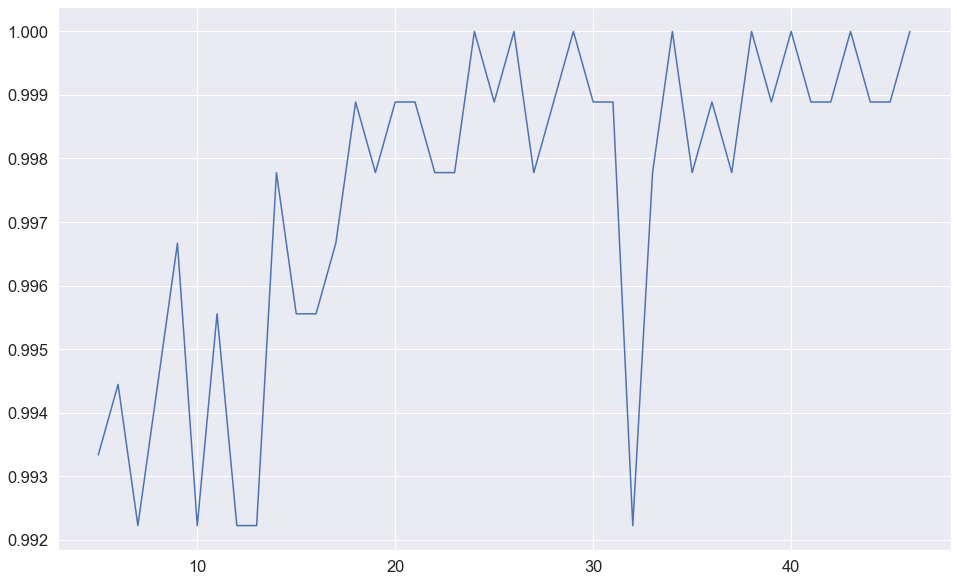

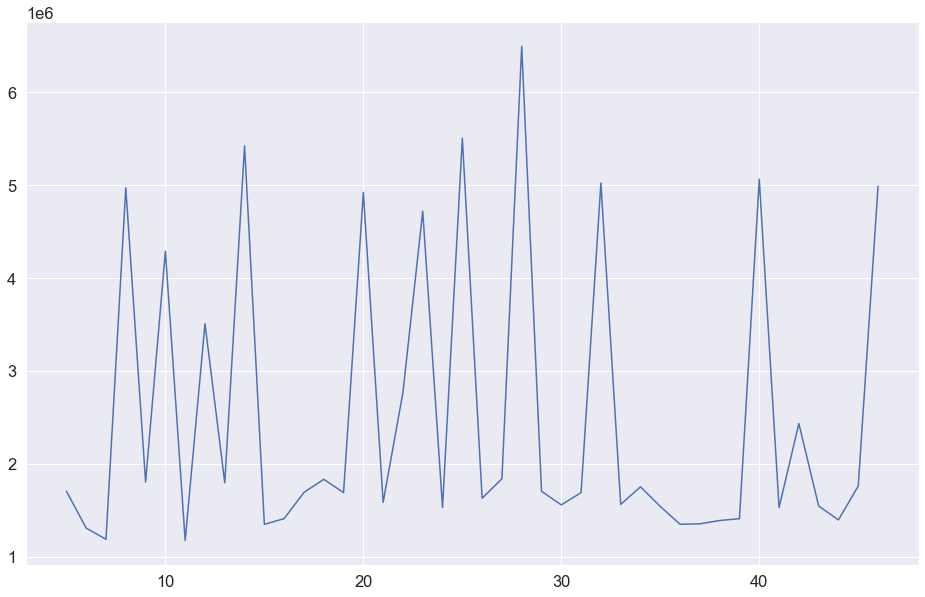

In [31]:
plt.figure(figsize=(16, 10))
plt.plot(
    np.arange(5, len(sorted_metrics)),
    history['accuracy']
)
plt.title("График зависимости Accuracy от числа метрик")
plt.xlabel("Число метрик")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(
    np.arange(5, len(sorted_metrics)),
    history['time_predict']
)
plt.title("График зависимости времени предсказания от числа метрик")
plt.xlabel("Число метрик")
plt.ylabel("Время предсказания, нс")
plt.show()

### Все ли ок?

In [31]:
params = results['params']

In [32]:
params

{'depth': 2, 'iterations': 100, 'learning_rate': 0.17500000000000002}

In [33]:
model = CatBoostClassifier(eval_metric='Accuracy', 
                           use_best_model=True, random_seed=0, 
                           max_depth=3,
                           n_estimators=1000,
                           learning_rate=0.47
                          )

In [34]:
model.fit(train_pool, eval_set=test_pool, metric_period=100)

0:	learn: 0.8000000	test: 0.6923077	best: 0.6923077 (0)	total: 395us	remaining: 395ms
100:	learn: 1.0000000	test: 0.8461538	best: 0.8461538 (100)	total: 45ms	remaining: 400ms
200:	learn: 1.0000000	test: 0.8461538	best: 0.8461538 (100)	total: 66.4ms	remaining: 264ms
300:	learn: 1.0000000	test: 0.7692308	best: 0.8461538 (100)	total: 85.5ms	remaining: 199ms
400:	learn: 1.0000000	test: 0.7692308	best: 0.8461538 (100)	total: 104ms	remaining: 156ms
500:	learn: 1.0000000	test: 0.7692308	best: 0.8461538 (100)	total: 124ms	remaining: 123ms
600:	learn: 1.0000000	test: 0.7692308	best: 0.8461538 (100)	total: 144ms	remaining: 95.4ms
700:	learn: 1.0000000	test: 0.7692308	best: 0.8461538 (100)	total: 163ms	remaining: 69.7ms
800:	learn: 1.0000000	test: 0.7692308	best: 0.8461538 (100)	total: 183ms	remaining: 45.5ms
900:	learn: 1.0000000	test: 0.7692308	best: 0.8461538 (100)	total: 216ms	remaining: 23.8ms
999:	learn: 1.0000000	test: 0.7692308	best: 0.8461538 (100)	total: 236ms	remaining: 0us

bestTest =

In [35]:
for value, name in sorted(
    zip(model.get_feature_importance(fstr_type="FeatureImportance"), 
        X_train.columns), 
    reverse=True
):
    print("{}\t{:.2f}".format(name, value))

z_min	29.35
z_energy	18.59
xy_corr	13.08
y_mean	6.04
z_mean	5.31
x_energy	4.89
z_iqr	4.44
y_max	4.22
x_mean_pos1	3.59
x_std	3.54
x_iqr	3.04
y_energy	1.14
z_std	0.87
xz_corr	0.73
x_max	0.70
x_min	0.17
x_mean	0.12
z_max	0.11
yz_corr	0.04
y_min	0.02
y_std	0.00
y_iqr	0.00
sma	0.00
sex	0.00
mass	0.00
height	0.00


Задачи:
1. Замерить время извлечения каждой метрики и выбрать самые оптимальные.
2. Избавиться от лишних метрик в модели.